# Time Series for Individual Points 

In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
from mpl_toolkits.axes_grid1 import ImageGrid
import pylab
from matplotlib import gridspec
import matplotlib

## Load data

In [2]:
cat = pd.read_csv('/data/keeling/a/cristi/a/esm_data/cmip6_catalog.csv')
cat

activity_id branch_method branch_time_in_child branch_time_in_parent  \
0             CMIP      standard                  0.0                   0.0   
1             CMIP      standard                  0.0                   0.0   
2             CMIP      standard                  0.0                   0.0   
3             CMIP      standard                  0.0                   0.0   
4             CMIP      standard                  0.0                   0.0   
...            ...           ...                  ...                   ...   
11429  ScenarioMIP      standard              59400.0               59400.0   
11430  ScenarioMIP      standard              59400.0               59400.0   
11431  ScenarioMIP      standard              59400.0               59400.0   
11432  ScenarioMIP      standard              59400.0               59400.0   
11433  ScenarioMIP      standard              59400.0               59400.0   

                           experiment experiment_id frequency  \
0           abrupt quadrupling of CO2  abrupt-4xCO2       mon   
1           abrupt quadrupling of CO2  abrupt-4xCO2       mon   
2           abrupt quadrupling of CO2  abrupt-4xCO2       mon   
3           abrupt quadrupling of CO2  abrupt-4xCO2       mon   
4           abrupt quadrupling of CO2  abrupt-4xCO2       mon   
...                               ...           ...       ...   
11429  update of RCP8.5 based on SSP5        ssp585       mon   
11430  update of RCP8.5 based on SSP5        ssp585       mon   
11431  update of RCP8.5 based on SSP5        ssp585       mon   
11432  update of RCP8.5 based on SSP5        ssp585       mon   
11433  update of RCP8.5 based on SSP5        ssp585       mon   

                                                grid grid_label  \
0       native atmosphere N96 grid (144x192 latxlon)         gn   
1       native atmosphere N96 grid (144x192 latxlon)         gn   
2       native atmosphere N96 grid (144x192 latxlon)         gn   
3       native atmosphere N96 grid (144x192 latxlon)         gn   
4       native atmosphere N96 grid (144x192 latxlon)         gn   
...                                              ...        ...   
11429  Native N96 grid; 192 x 144 longitude/latitude         gn   
11430  Native N96 grid; 192 x 144 longitude/latitude         gn   
11431  Native N96 grid; 192 x 144 longitude/latitude         gn   
11432  Native N96 grid; 192 x 144 longitude/latitude         gn   
11433  Native N96 grid; 192 x 144 longitude/latitude         gn   

      institution_id  ...                              standard_name  \
0       CSIRO-ARCCSS  ...            surface_upward_latent_heat_flux   
1       CSIRO-ARCCSS  ...          surface_upward_sensible_heat_flux   
2       CSIRO-ARCCSS  ...   surface_downwelling_longwave_flux_in_air   
3       CSIRO-ARCCSS  ...     surface_upwelling_longwave_flux_in_air   
4       CSIRO-ARCCSS  ...                 toa_outgoing_longwave_flux   
...              ...  ...                                        ...   
11429           MOHC  ...  surface_downwelling_shortwave_flux_in_air   
11430           MOHC  ...                toa_incoming_shortwave_flux   
11431           MOHC  ...    surface_upwelling_shortwave_flux_in_air   
11432           MOHC  ...                toa_outgoing_shortwave_flux   
11433           MOHC  ...                            air_temperature   

                                     long_name  units vertical_levels  \
0              Surface Upward Latent Heat Flux  W m-2             1.0   
1            Surface Upward Sensible Heat Flux  W m-2             1.0   
2       Surface Downwelling Longwave Radiation  W m-2             1.0   
3         Surface Upwelling Longwave Radiation  W m-2             1.0   
4              TOA Outgoing Longwave Radiation  W m-2             1.0   
...                                        ...    ...             ...   
11429  Surface Downwelling Shortwave Radiation  W m-2             1.0   
11430         TOA Incid

## CANESM - Control Data

In [3]:
path_canesm_control = cat.loc[(cat['variable_id']=='tas') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control')) &
               (cat['source_id']=='CanESM5') &
               (cat['variant_label']=='r1i1p1f1')]['path'].to_list()
path_canesm_control = path_canesm_control[1:] # First two files are copies of each other
path_canesm_control

['/data/cristi/a/cristi/esm_data/cmip6/CanESM5/piControl/r1i1p1f1/tas_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/CanESM5/piControl/r1i1p1f1/tas_Amon_CanESM5_piControl_r1i1p1f1_gn_540101-560012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/CanESM5/piControl/r1i1p1f1/tas_Amon_CanESM5_piControl_r1i1p1f1_gn_560101-580012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/CanESM5/piControl/r1i1p1f1/tas_Amon_CanESM5_piControl_r1i1p1f1_gn_580101-600012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/CanESM5/piControl/r1i1p1f1/tas_Amon_CanESM5_piControl_r1i1p1f1_gn_600101-620012.nc']

In [4]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_canesm_control = []

for file in path_canesm_control:
    ds = xr.open_dataset(file)
    ds = ds.tas.interp(lat=new_lats,lon=new_lons)
    dset_list_canesm_control.append(ds)

In [5]:
canesm_control_ds = xr.concat(dset_list_canesm_control, dim='time', coords='minimal', compat='override')
canesm_control_ds

<xarray.DataArray 'tas' (time: 21600, lat: 88, lon: 179)>
array([[[248.47676926, 248.23956786, 247.99810656, ..., 249.48870117,
         249.24198279, 248.98708932],
        [248.32550863, 247.92152079, 247.57209653, ..., 250.16679686,
         249.68724792, 249.20676176],
        [247.628947  , 247.08414588, 246.63603833, ..., 250.06167812,
         249.43169963, 248.81753341],
        ...,
        [241.7883766 , 242.30465107, 242.76446638, ..., 239.50405786,
         240.05321846, 240.62731302],
        [241.79001622, 242.01869329, 242.19770795, ..., 240.53132627,
         240.89125994, 241.23692038],
        [242.0675244 , 242.18481633, 242.26122206, ..., 241.49623913,
         241.68512692, 241.84877712]],

       [[237.20443977, 236.96226686, 236.71971423, ..., 238.33340194,
         238.03154947, 237.73963945],
        [235.96643628, 235.59917477, 235.27705561, ..., 237.87394499,
         237.32810064, 236.81679501],
        [235.33627835, 234.93439938, 234.62812973, ..., 237.5660348 ,
         236.89709703, 236.29453001],
...
        [247.41363702, 247.85418111, 248.17888463, ..., 245.65264229,
         246.10198858, 246.47850499],
        [248.1347903 , 248.44609738, 248.62821766, ..., 246.82438206,
         247.12587494, 247.43223407],
        [247.5701018 , 247.71990845, 247.79713425, ..., 246.98519945,
         247.13008242, 247.26803377]],

       [[250.97594993, 250.79764525, 250.60875459, ..., 251.75837734,
         251.55481881, 251.35335232],
        [250.55657648, 250.25096906, 249.9517129 , ..., 252.01165313,
         251.61866665, 251.21224833],
        [249.7328767 , 249.39051131, 249.09542607, ..., 251.42475172,
         250.97649903, 250.51488418],
        ...,
        [235.18878813, 235.50671345, 235.70873042, ..., 233.58078648,
         233.93374419, 234.39574861],
        [233.21137808, 233.34387488, 233.46064128, ..., 232.51708631,
         232.73522962, 232.91212993],
        [233.2401387 , 233.275921  , 233.28659679, ..., 233.06343842,
         233.12681118, 233.14105115]]])
Coordinates:
    height   float64 2.0
  * time     (time) object 5201-01-16 12:00:00 ... 6200-12-16 12:00:00
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        ST+273.16, CMIP_table_comment: near-surface (usually, 2 m...
    long_name:      Near-Surface Air Temperature
    original_name:  ST
    standard_name:  air_temperature
    units:          K

In [29]:
canesm_control = canesm_control_ds.rolling(time=300, center=True).mean('time') #12*25 = 300 - 25 Years
canesm_control.load()

<xarray.DataArray 'tas' (time: 21600, lat: 88, lon: 179)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    height   float64 2.0
  * time     (time) object 5201-01-16 12:00:00 ... 6200-12-16 12:00:00
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        ST+273.16, CMIP_table_comment: near-surface (usually, 2 m...
    long_name:      Near-Surface Air Temperature
    original_name:  ST
    standard_name:  air_temperature
    units:          K

## Historical Data

In [6]:
path_canesm_hist = cat.loc[(cat['variable_id']=='tas') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id']=='historical') &
               (cat['source_id']=='CanESM5')].head(5)['path'].to_list()
path_canesm_hist = path_canesm_hist[0]
path_canesm_hist

'/data/cristi/a/cristi/esm_data/cmip6/CanESM5/historical/r10i1p1f1/tas_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412.nc'

In [31]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

canesm_hist_ds = xr.open_dataset(path_canesm_hist)
canesm_hist = canesm_hist_ds.tas.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
#canesm_hist = canesm_hist_ds.tas.rolling(time=300, center=True).mean('time')
canesm_hist.load()

<xarray.DataArray 'tas' (time: 1980, lat: 88, lon: 179)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    height   float64 2.0
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        ST+273.16, CMIP_table_comment: near-surface (usually, 2 m...
    history:        degctok 2019-04-30T17:40:12Z altered by CMOR: Treated sca...
    long_name:      Near-Surface Air Temperature
    original_name:  ST
    standard_name:  air_temperature
    units:          K

# Create the interdecadal variability summary plot

In [32]:
summary_cont = canesm_control.std('time')
summary_cont.load()
summary_hist = canesm_hist.std('time')
summary_hist.load()

<xarray.DataArray 'tas' (lat: 88, lon: 179)>
array([[0.37530915, 0.37749014, 0.37955041, ..., 0.36725203, 0.36918571,
        0.37104607],
       [0.38639879, 0.39076009, 0.39459886, ..., 0.37065675, 0.3744999 ,
        0.37813753],
       [0.40105678, 0.40423769, 0.40628578, ..., 0.37965166, 0.38610095,
        0.39146933],
       ...,
       [0.87450069, 0.88141913, 0.88909864, ..., 0.82518169, 0.84110522,
        0.85507528],
       [0.85026499, 0.85664449, 0.86182023, ..., 0.81215791, 0.82357141,
        0.83399049],
       [0.73191763, 0.73420342, 0.7358034 , ..., 0.7172176 , 0.7215322 ,
        0.72553054]])
Coordinates:
    height   float64 2.0
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - CanESM5')

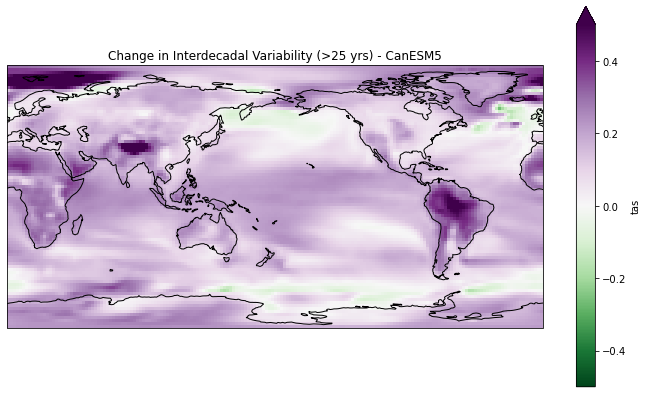

In [12]:
diff_canesm = summary_hist - summary_cont

plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
diff_canesm.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.title('Change in Interdecadal Variability (>25 yrs) - CanESM5')

Text(0.5, 1.0, 'Percent Change in Interdecadal Variability (>25 yrs) - CanESM5')

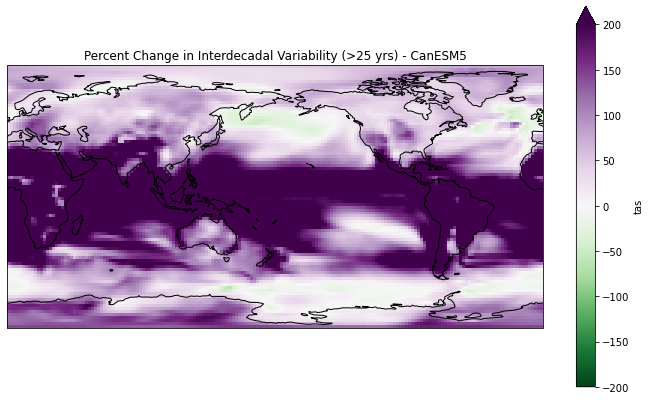

In [13]:
percent_canesm = ((diff_canesm)/summary_cont)*100

plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_canesm.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.title('Percent Change in Interdecadal Variability (>25 yrs) - CanESM5')

# (180,53)

In [14]:
time_series_cont = canesm_control.sel(lat=53,method='nearest').sel(lon=180,method='nearest').isel(time=slice(300,1980))
time_series_hist = canesm_hist.sel(lat=53,method='nearest').sel(lon=180,method='nearest').isel(time=slice(300,1980))

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - CanESM5')

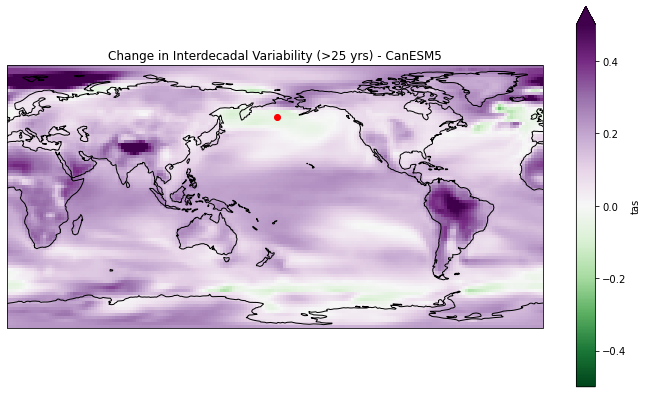

In [15]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
diff_canesm.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.plot(180,53, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Change in Interdecadal Variability (>25 yrs) - CanESM5')

Text(0.5, 1.0, 'Percent Change in Interdecadal Variability (>25 yrs) - CanESM5')

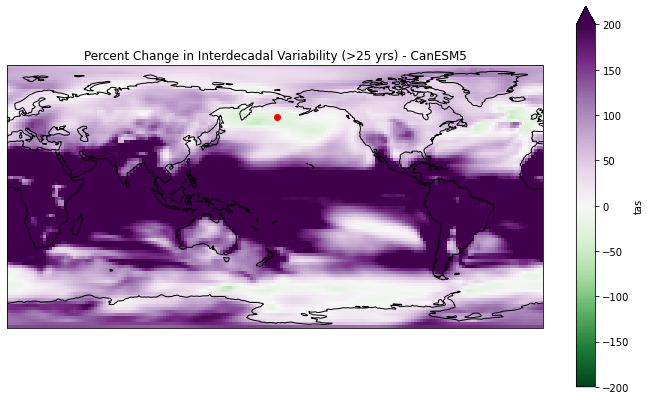

In [16]:
percent_canesm = ((diff_canesm)/summary_cont)*100

plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_canesm.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.plot(180,53, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Percent Change in Interdecadal Variability (>25 yrs) - CanESM5')

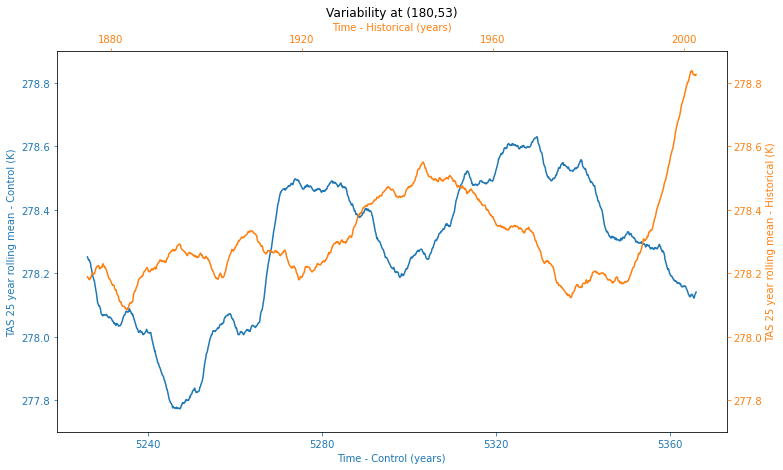

In [17]:
# https://stackoverflow.com/questions/42734109/two-or-more-graphs-in-one-plot-with-different-x-axis-and-y-axis-scales-in-pyth
fig = plt.figure()
ax = fig.add_subplot(111, label="Control")
ax2 = fig.add_subplot(111, label="Historical", frame_on=False)

plt.title('Variability at (180,53)')
ax.plot(time_series_cont['time'].values,time_series_cont, color="C0")
ax.set_xlabel('Time - Control (years)', color="C0")
ax.set_ylabel('TAS 25 year rolling mean - Control (K)', color="C0")
ax.set_ylim(bottom=277.7,top=278.9)
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.plot(time_series_hist['time'].values,time_series_hist, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Time - Historical (years)', color="C1") 
ax2.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="C1")  
ax2.set_ylim(top=278.9,bottom=277.7)
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")

# (180,0)

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - CanESM5')

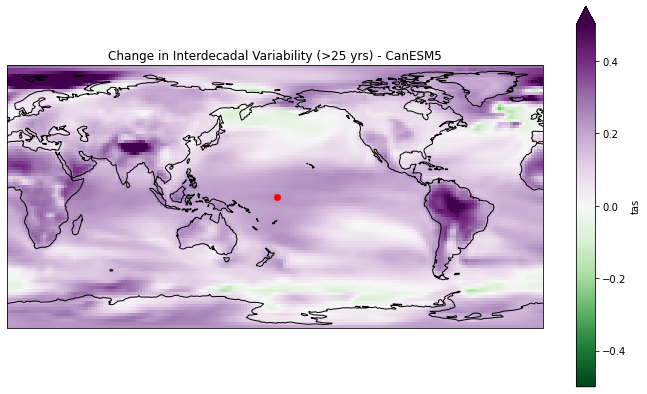

In [18]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
diff_canesm.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.plot(180,0, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Change in Interdecadal Variability (>25 yrs) - CanESM5')

Text(0.5, 1.0, 'Percent Change in Interdecadal Variability (>25 yrs) - CanESM5')

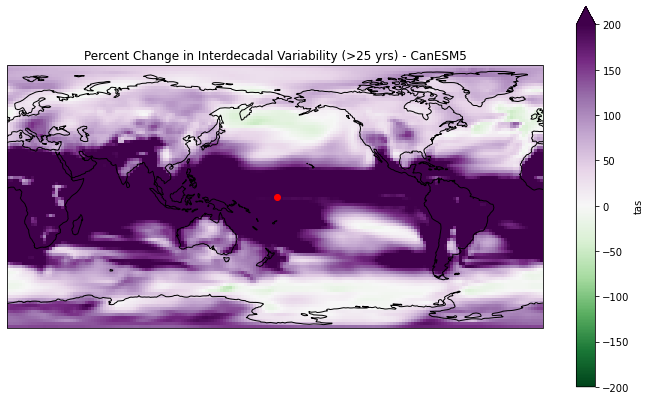

In [19]:
percent_canesm = ((diff_canesm)/summary_cont)*100

plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_canesm.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.plot(180,0, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Percent Change in Interdecadal Variability (>25 yrs) - CanESM5')

In [20]:
time_series_cont_2 = canesm_control.sel(lat=0,method='nearest').sel(lon=180,method='nearest').isel(time=slice(300,1980))
time_series_hist_2 = canesm_hist.sel(lat=0,method='nearest').sel(lon=180,method='nearest').isel(time=slice(300,1980))

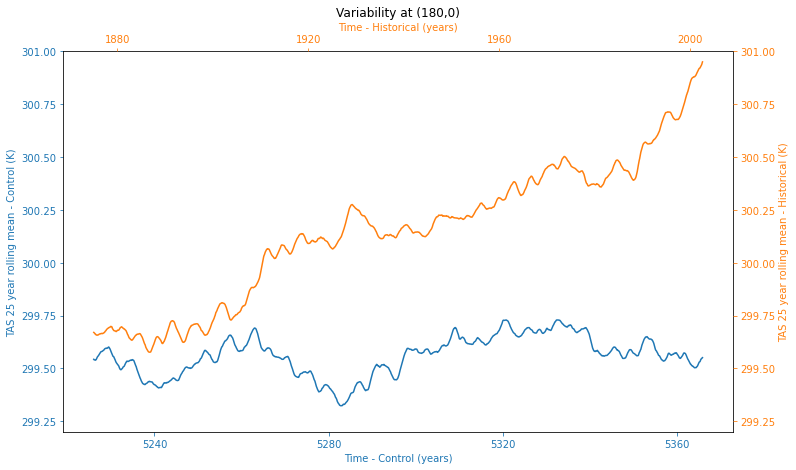

In [21]:
# https://stackoverflow.com/questions/42734109/two-or-more-graphs-in-one-plot-with-different-x-axis-and-y-axis-scales-in-pyth
fig = plt.figure()
ax = fig.add_subplot(111, label="Control")
ax2 = fig.add_subplot(111, label="Historical", frame_on=False)

plt.title('Variability at (180,0)')
ax.plot(time_series_cont_2['time'].values,time_series_cont_2, color="C0")
ax.set_xlabel('Time - Control (years)', color="C0")
ax.set_ylabel('TAS 25 year rolling mean - Control (K)', color="C0")
ax.set_ylim(bottom=299.2,top=301)
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.plot(time_series_hist_2['time'].values,time_series_hist_2, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Time - Historical (years)', color="C1") 
ax2.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="C1")  
ax2.set_ylim(top=301,bottom=299.2)
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")

# (15,77)

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - CanESM5')

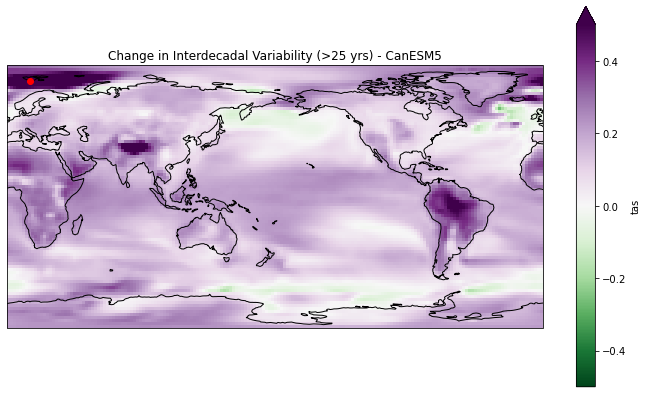

In [22]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
diff_canesm.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.plot(15,77, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Change in Interdecadal Variability (>25 yrs) - CanESM5')

Text(0.5, 1.0, 'Percent Change in Interdecadal Variability (>25 yrs) - CanESM5')

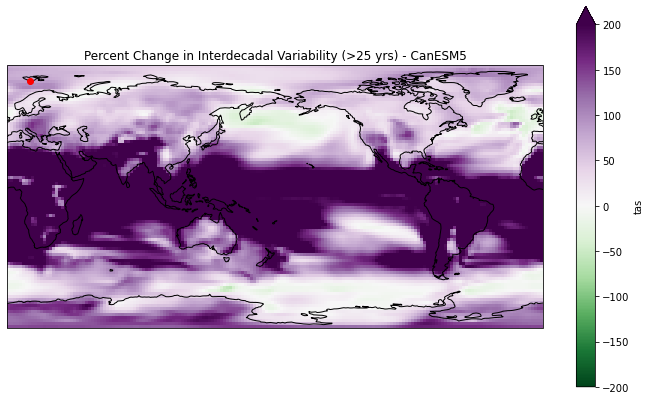

In [23]:
percent_canesm = ((diff_canesm)/summary_cont)*100

plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_canesm.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.plot(15,77, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Percent Change in Interdecadal Variability (>25 yrs) - CanESM5')

In [24]:
time_series_cont_3 = canesm_control.sel(lat=77,method='nearest').sel(lon=15,method='nearest').isel(time=slice(300,1980))
time_series_hist_3 = canesm_hist.sel(lat=77,method='nearest').sel(lon=15,method='nearest').isel(time=slice(300,1980))

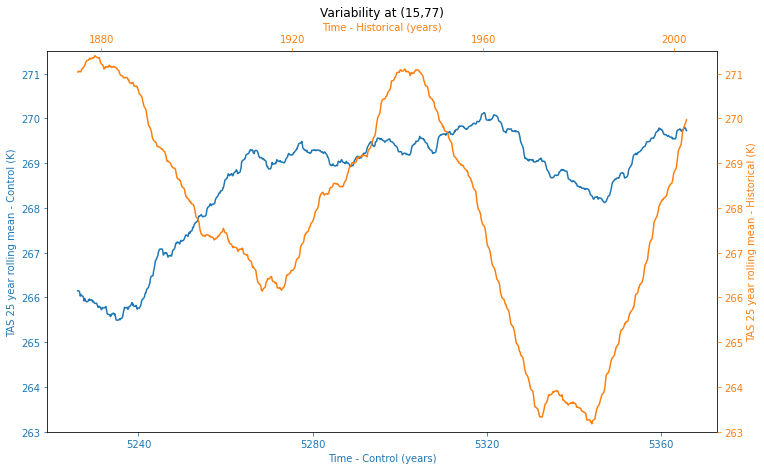

In [25]:
# https://stackoverflow.com/questions/42734109/two-or-more-graphs-in-one-plot-with-different-x-axis-and-y-axis-scales-in-pyth
fig = plt.figure()
ax = fig.add_subplot(111, label="Control")
ax2 = fig.add_subplot(111, label="Historical", frame_on=False)

plt.title('Variability at (15,77)')
ax.plot(time_series_cont_3['time'].values,time_series_cont_3, color="C0")
ax.set_xlabel('Time - Control (years)', color="C0")
ax.set_ylabel('TAS 25 year rolling mean - Control (K)', color="C0")
ax.set_ylim(bottom=263,top=271.5)
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.plot(time_series_hist_3['time'].values,time_series_hist_3, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Time - Historical (years)', color="C1") 
ax2.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="C1")  
ax2.set_ylim(top=271.5,bottom=263)
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")

# (146,-62)

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - CanESM5')

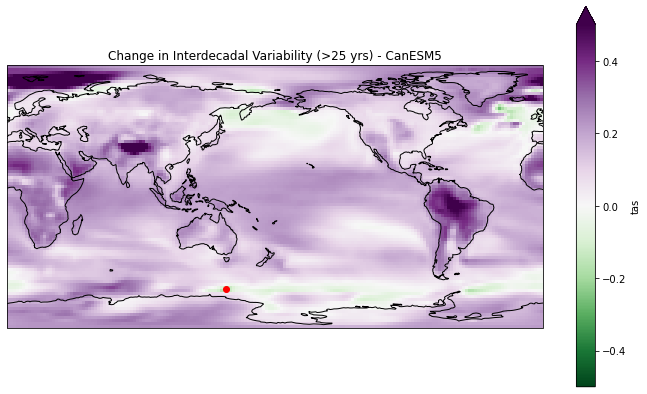

In [26]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
diff_canesm.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.plot(146,-62, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Change in Interdecadal Variability (>25 yrs) - CanESM5')

Text(0.5, 1.0, 'Percent Change in Interdecadal Variability (>25 yrs) - CanESM5')

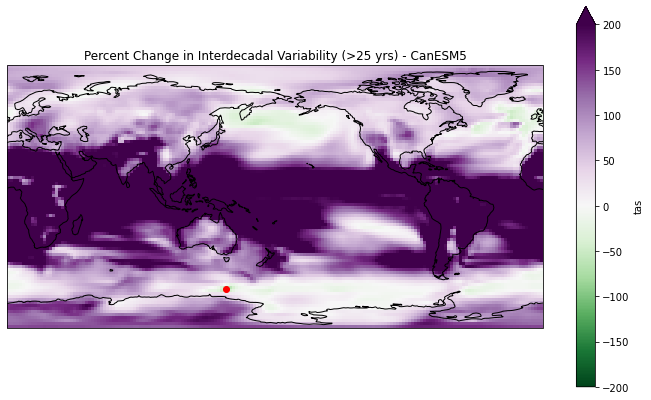

In [27]:
percent_canesm = ((diff_canesm)/summary_cont)*100

plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_canesm.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.plot(146,-62, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Percent Change in Interdecadal Variability (>25 yrs) - CanESM5')

In [28]:
time_series_cont_4 = canesm_control.sel(lat=-62,method='nearest').sel(lon=146,method='nearest').isel(time=slice(300,1980))
time_series_hist_4 = canesm_hist.sel(lat=-62,method='nearest').sel(lon=146,method='nearest').isel(time=slice(300,1980))

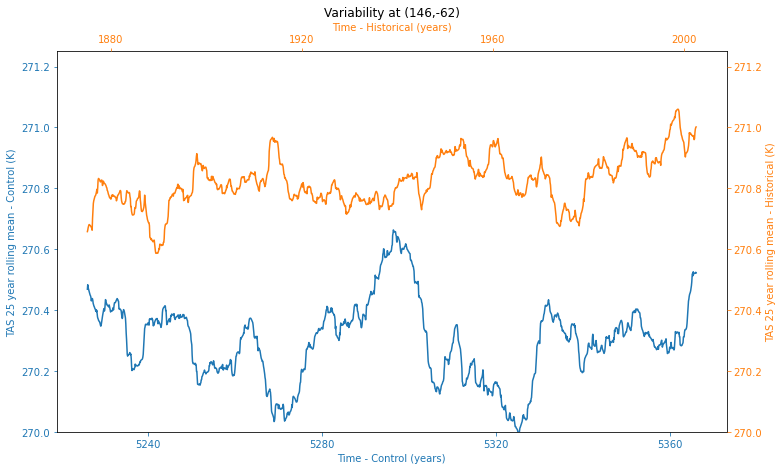

In [29]:
# https://stackoverflow.com/questions/42734109/two-or-more-graphs-in-one-plot-with-different-x-axis-and-y-axis-scales-in-pyth
fig = plt.figure()
ax = fig.add_subplot(111, label="Control")
ax2 = fig.add_subplot(111, label="Historical", frame_on=False)

plt.title('Variability at (146,-62)')
ax.plot(time_series_cont_4['time'].values,time_series_cont_4, color="C0")
ax.set_xlabel('Time - Control (years)', color="C0")
ax.set_ylabel('TAS 25 year rolling mean - Control (K)', color="C0")
ax.set_ylim(bottom=270,top=271.25)
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.plot(time_series_hist_4['time'].values,time_series_hist_4, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Time - Historical (years)', color="C1") 
ax2.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="C1")  
ax2.set_ylim(top=271.25,bottom=270)
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")

# Plotting all together

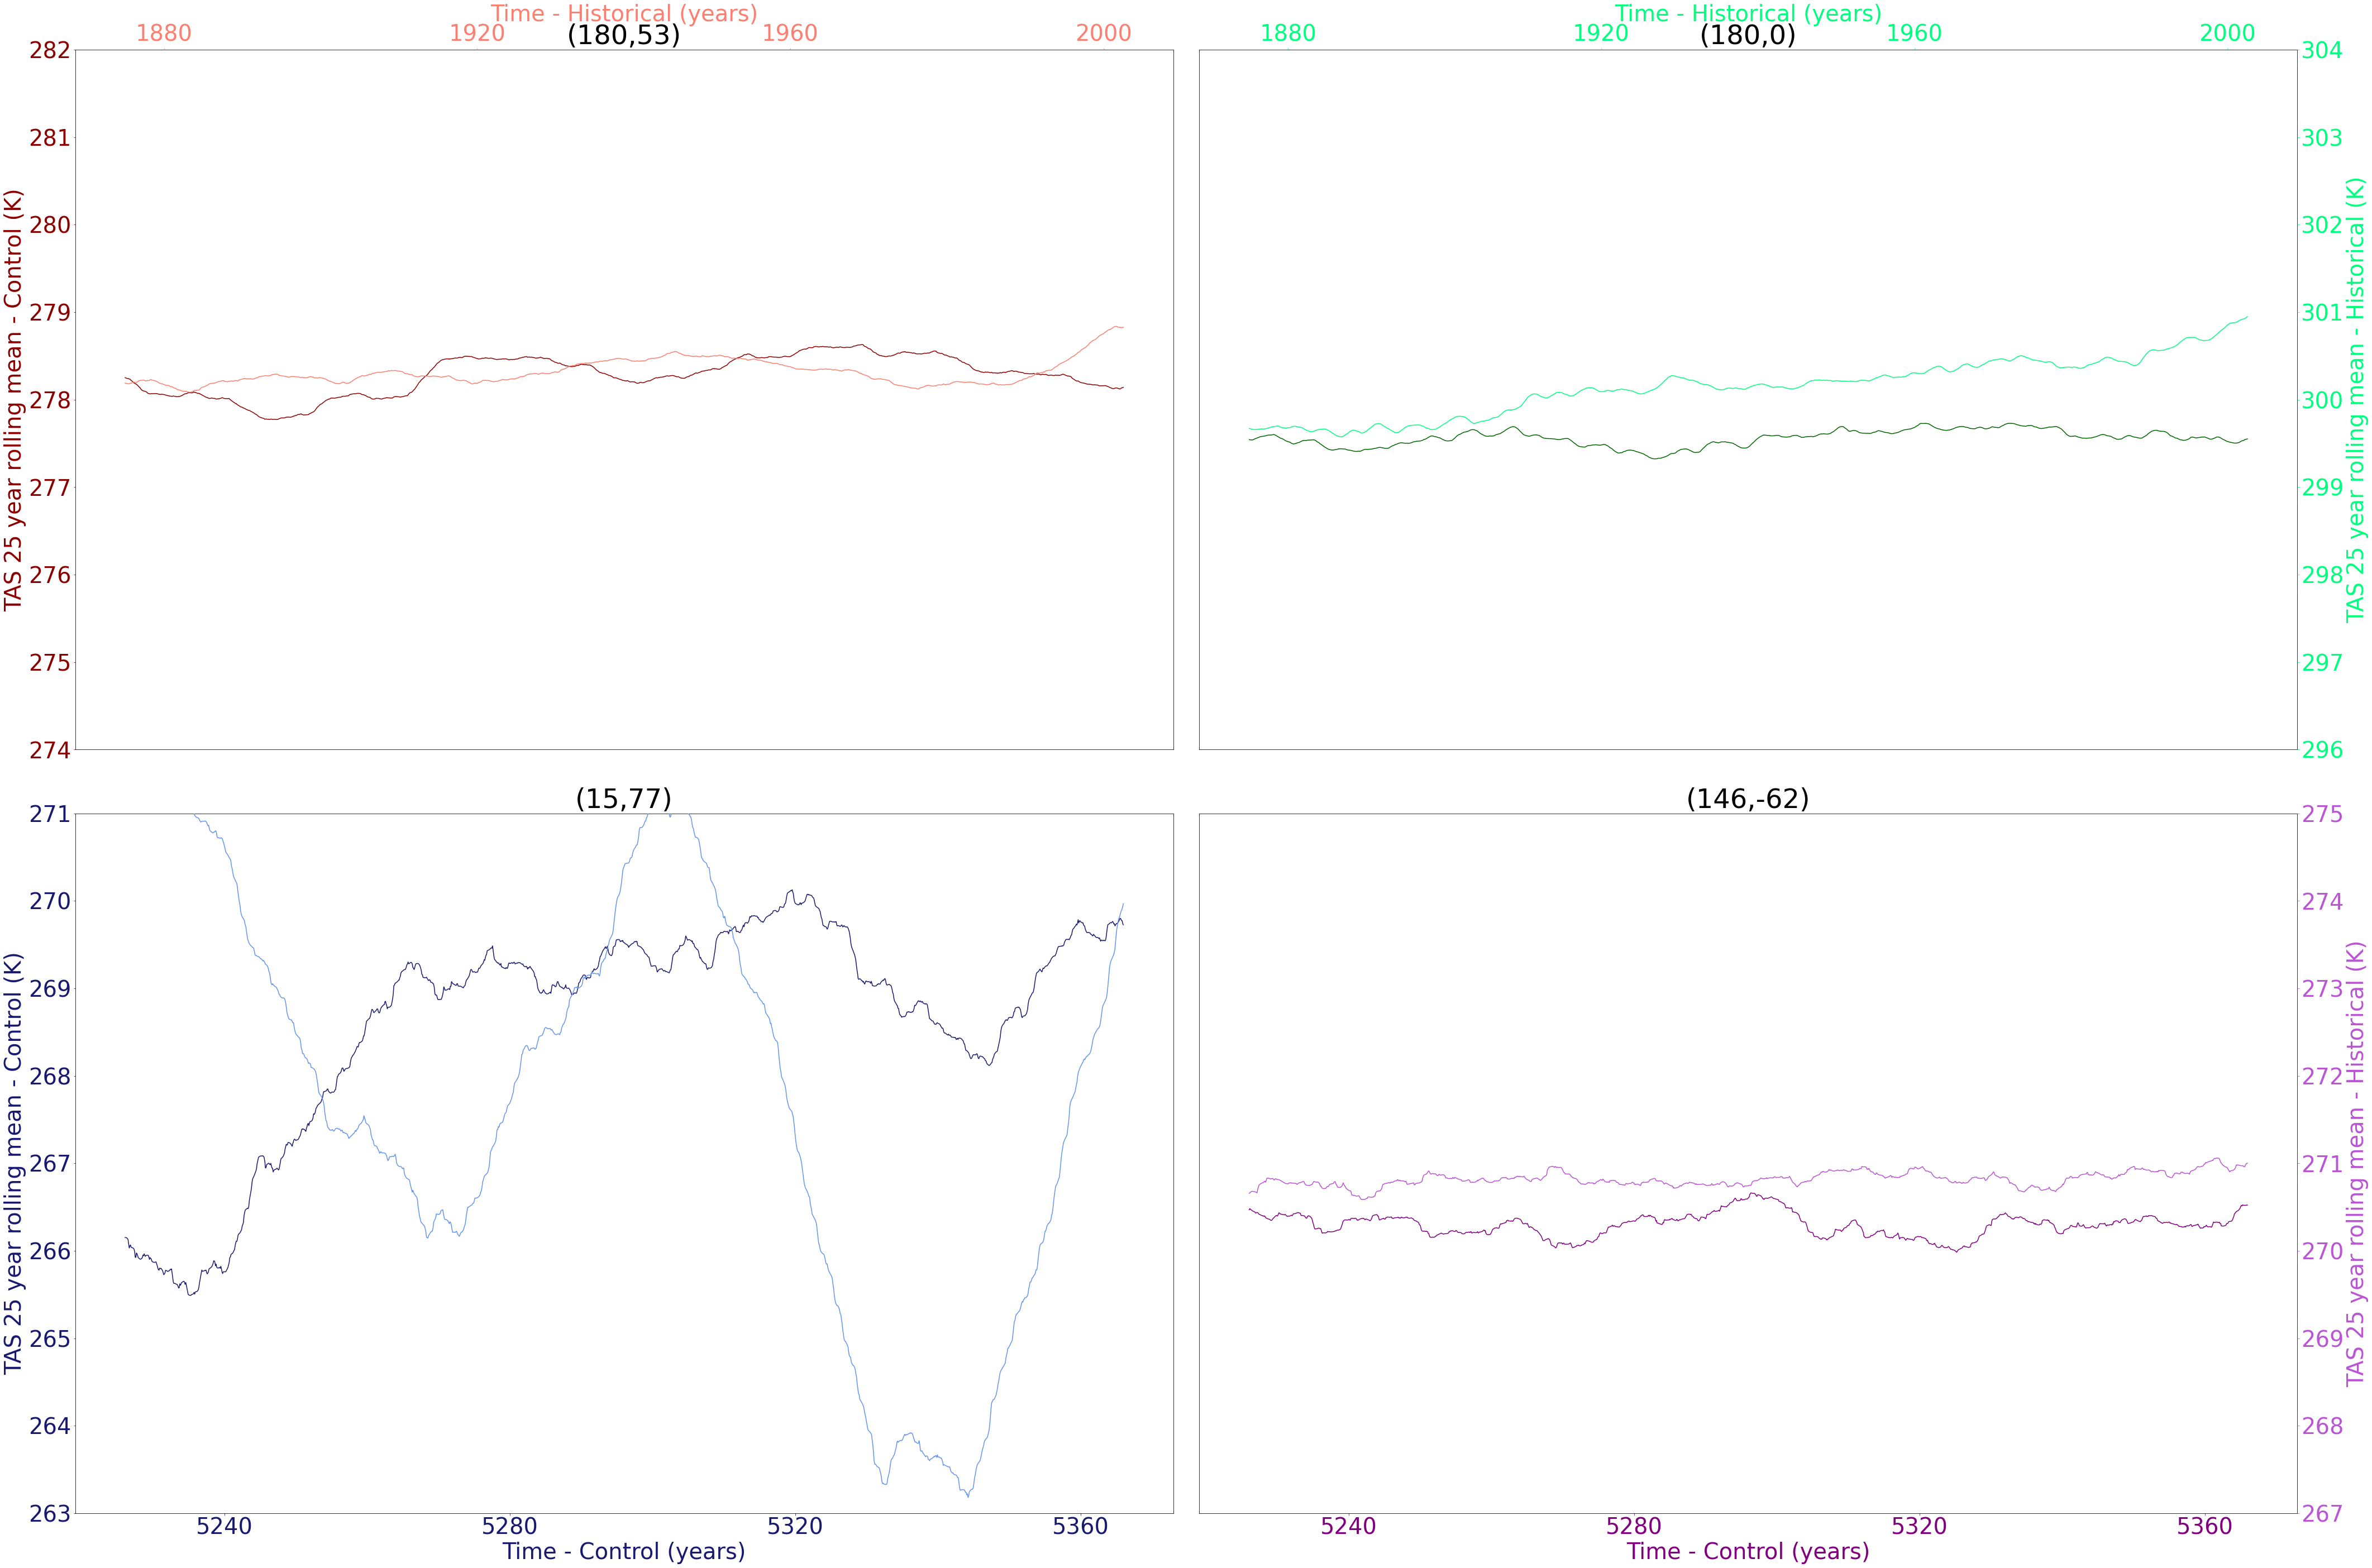

In [92]:
nrow = 1
ncol = 4
fig = plt.figure(figsize=(60, 40))
#grid = ImageGrid(fig, 
#                 111, # as in plt.subplot(111)
#                 nrows_ncols=(nrow,ncol),
#                 axes_pad=0,
#                 share_all=True,)

#for i in range(1):
#    for j in range(2):
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.1)
top=300
bottom=270
font = {'size'   : 40,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

#plt.subplot(gs[0,0])
ax = fig.add_subplot(221, label="Control")
ax2 = fig.add_subplot(221, label="Historical", frame_on=False)
ax.set_title('(180,53)')
ax.xaxis.set_visible(False)
ax.plot(time_series_cont['time'].values,time_series_cont, color="darkred")
ax.set_xlabel('Time - Control (years)', color="darkred")
ax.set_ylabel('TAS 25 year rolling mean - Control (K)', color="darkred")
ax.set_ylim(bottom=274,top=282)
ax.tick_params(axis='x', colors="darkred")
ax.tick_params(axis='y', colors="darkred")

ax2.plot(time_series_hist['time'].values,time_series_hist, color="salmon")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Time - Historical (years)', color="salmon") 
ax2.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="salmon")  
ax2.set_ylim(top=282,bottom=274)
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_visible(False)
ax2.tick_params(axis='x', colors="salmon")
ax2.tick_params(axis='y', colors="salmon")

#plt.subplot(gs[0,1])
ax3 = fig.add_subplot(222, label="Control")
ax4 = fig.add_subplot(222, label="Historical", frame_on=False)
ax3.set_title('(180,0)')
ax3.yaxis.set_visible(False)
ax3.xaxis.set_visible(False)
ax3.plot(time_series_cont_2['time'].values,time_series_cont_2, color="darkgreen")
ax3.set_xlabel('Time - Control (years)', color="darkgreen")
ax3.set_ylabel('TAS 25 year rolling mean - Control (K)', color="darkgreen")
ax3.set_ylim(bottom=296,top=304)
ax3.tick_params(axis='x', colors="darkgreen")
ax3.tick_params(axis='y', colors="darkgreen")

ax4.plot(time_series_hist_2['time'].values,time_series_hist_2, color="springgreen")
ax4.xaxis.tick_top()
ax4.yaxis.tick_right()
#ax4.yaxis.set_visible(False)
ax4.set_xlabel('Time - Historical (years)', color="springgreen") 
ax4.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="springgreen")  
ax4.set_ylim(top=304,bottom=296)
ax4.xaxis.set_label_position('top') 
ax4.yaxis.set_label_position('right') 
ax4.tick_params(axis='x', colors="springgreen")
ax4.tick_params(axis='y', colors="springgreen")

ax5 = fig.add_subplot(223, label="Control")
ax6 = fig.add_subplot(223, label="Historical", frame_on=False)
#ax5.yaxis.set_visible(False)
ax5.set_title('(15,77)')
ax5.plot(time_series_cont_3['time'].values,time_series_cont_3, color="midnightblue")
ax5.set_xlabel('Time - Control (years)', color="midnightblue")
ax5.set_ylabel('TAS 25 year rolling mean - Control (K)', color="midnightblue")
ax5.set_ylim(bottom=263,top=271)
ax5.tick_params(axis='x', colors="midnightblue")
ax5.tick_params(axis='y', colors="midnightblue")

ax6.plot(time_series_hist_3['time'].values,time_series_hist_3, color="cornflowerblue")
ax6.xaxis.tick_top()
ax6.yaxis.tick_right()
ax6.xaxis.set_visible(False)
ax6.yaxis.set_visible(False)
ax6.set_xlabel('Time - Historical (years)', color="cornflowerblue") 
ax6.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="cornflowerblue")  
ax6.set_ylim(top=271,bottom=263)
ax6.xaxis.set_label_position('top') 
ax6.yaxis.set_label_position('right') 
ax6.tick_params(axis='x', colors="cornflowerblue")
ax6.tick_params(axis='y', colors="cornflowerblue")

ax7 = fig.add_subplot(224, label="Control")
ax8 = fig.add_subplot(224, label="Historical", frame_on=False)
ax7.yaxis.set_visible(False)
ax7.set_title('(146,-62)')
ax7.plot(time_series_cont_4['time'].values,time_series_cont_4, color="purple")
ax7.set_xlabel('Time - Control (years)', color="purple")
ax7.set_ylabel('TAS 25 year rolling mean - Control (K)', color="purple")
ax7.set_ylim(bottom=267,top=275)
ax7.tick_params(axis='x', colors="purple")
ax7.tick_params(axis='y', colors="purple")

ax8.plot(time_series_hist_4['time'].values,time_series_hist_4, color="mediumorchid")
ax8.xaxis.tick_top()
ax8.yaxis.tick_right()
ax8.xaxis.set_visible(False)
#ax8.yaxis.set_visible(False)
ax8.set_xlabel('Time - Historical (years)', color="mediumorchid") 
ax8.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="mediumorchid")  
ax8.set_ylim(top=275,bottom=267)
ax8.xaxis.set_label_position('top') 
ax8.yaxis.set_label_position('right') 
ax8.tick_params(axis='x', colors="mediumorchid")
ax8.tick_params(axis='y', colors="mediumorchid")

# Get the current axis
ax = pylab.gca()

plt.tight_layout() # do not use this!!
plt.show()

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - CanESM5')

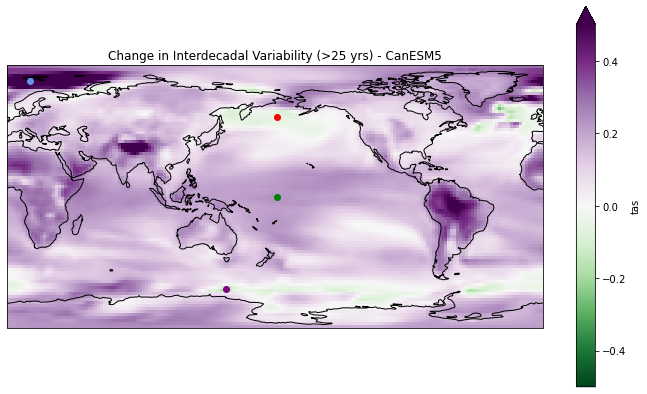

In [88]:
plt.rcParams['figure.figsize'] = [12, 7]
font = {'size'   : 10}
matplotlib.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
diff_canesm.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.plot(180,53, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(180,0, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(15,77, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(146,-62, marker='o', color='purple', transform=ccrs.PlateCarree())
plt.title('Change in Interdecadal Variability (>25 yrs) - CanESM5')

Text(0.5, 1.0, 'Percent Change in Interdecadal Variability (>25 yrs) - CanESM5')

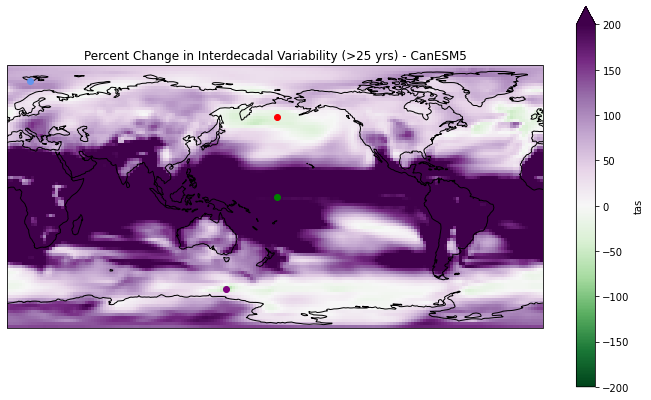

In [99]:
plt.rcParams['figure.figsize'] = [12, 7]
font = {'size'   : 10}
matplotlib.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_canesm.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.plot(180,53, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(180,0, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(15,77, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(146,-62, marker='o', color='purple', transform=ccrs.PlateCarree())
plt.title('Percent Change in Interdecadal Variability (>25 yrs) - CanESM5')

Text(0.5, 1.0, 'Control Interdecadal Variability (>25 yrs) - CanESM5')

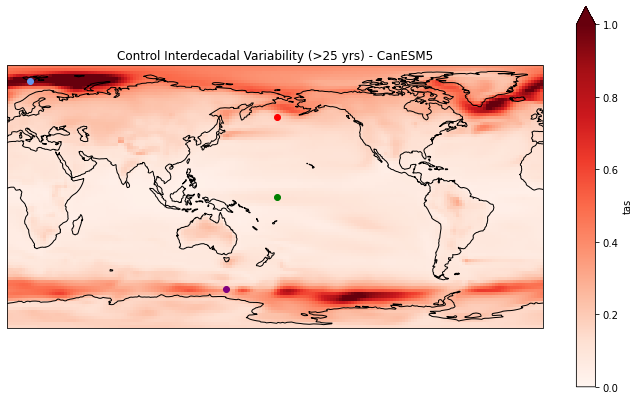

In [33]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
summary_cont.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)
plt.plot(180,53, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(180,0, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(15,77, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(146,-62, marker='o', color='purple', transform=ccrs.PlateCarree())
plt.title('Control Interdecadal Variability (>25 yrs) - CanESM5')

Text(0.5, 1.0, 'Historical Interdecadal Variability (>25 yrs) - CanESM5')

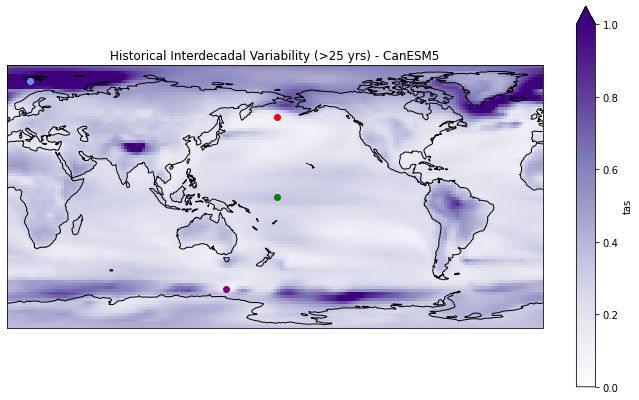

In [34]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
summary_hist.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Purples', vmin=0, vmax=1)
plt.plot(180,53, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(180,0, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(15,77, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(146,-62, marker='o', color='purple', transform=ccrs.PlateCarree())
ax.coastlines(color='black', linewidth=1)
plt.title('Historical Interdecadal Variability (>25 yrs) - CanESM5')

# With a 5 year time interval

In [7]:
canesm_5yr = canesm_control_ds.rolling(time=60, center=True).mean('time') #12*5 = 60
canesm_5yr.load()

<xarray.DataArray 'tas' (time: 21600, lat: 88, lon: 179)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    height   float64 2.0
  * time     (time) object 5201-01-16 12:00:00 ... 6200-12-16 12:00:00
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        ST+273.16, CMIP_table_comment: near-surface (usually, 2 m...
    long_name:      Near-Surface Air Temperature
    original_name:  ST
    standard_name:  air_temperature
    units:          K

In [8]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

canesm_hist_ds = xr.open_dataset(path_canesm_hist)
canesm_hist_5yr = canesm_hist_ds.tas.interp(lat=new_lats,lon=new_lons).rolling(time=60, center=True).mean('time')
#canesm_hist = canesm_hist_ds.tas.rolling(time=300, center=True).mean('time')
canesm_hist_5yr.load()

<xarray.DataArray 'tas' (time: 1980, lat: 88, lon: 179)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    height   float64 2.0
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        ST+273.16, CMIP_table_comment: near-surface (usually, 2 m...
    history:        degctok 2019-04-30T17:40:12Z altered by CMOR: Treated sca...
    long_name:      Near-Surface Air Temperature
    original_name:  ST
    standard_name:  air_temperature
    units:          K

In [9]:
summary_cont_5 = canesm_5yr.std('time')
summary_cont_5.load()
summary_hist_5 = canesm_hist_5yr.std('time')
summary_hist_5.load()

<xarray.DataArray 'tas' (lat: 88, lon: 179)>
array([[0.55949042, 0.56105884, 0.56257717, ..., 0.55364842, 0.55498113,
        0.55633243],
       [0.59435524, 0.597506  , 0.59944894, ..., 0.58160742, 0.58456201,
        0.58779573],
       [0.62169972, 0.62239474, 0.61928479, ..., 0.59865091, 0.60561032,
        0.61261252],
       ...,
       [1.44781456, 1.45852925, 1.47081775, ..., 1.38147329, 1.40214449,
        1.42164295],
       [1.43871046, 1.44821066, 1.45636605, ..., 1.38923881, 1.4044511 ,
        1.41799038],
       [1.33182733, 1.33635361, 1.34007771, ..., 1.30834391, 1.31528414,
        1.32182534]])
Coordinates:
    height   float64 2.0
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

Text(0.5, 1.0, 'Change in Interdecadal Variability (5 yrs) - CanESM5')

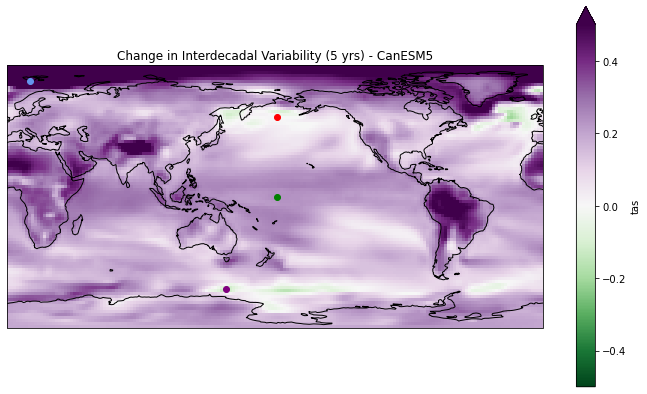

In [11]:
diff_5 = summary_hist_5 - summary_cont_5

plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
diff_5.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.plot(180,53, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(180,0, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(15,77, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(146,-62, marker='o', color='purple', transform=ccrs.PlateCarree())
plt.title('Change in Interdecadal Variability (5 yrs) - CanESM5')

Text(0.5, 1.0, 'Percent Change in Interdecadal Variability (5 yrs) - CanESM5')

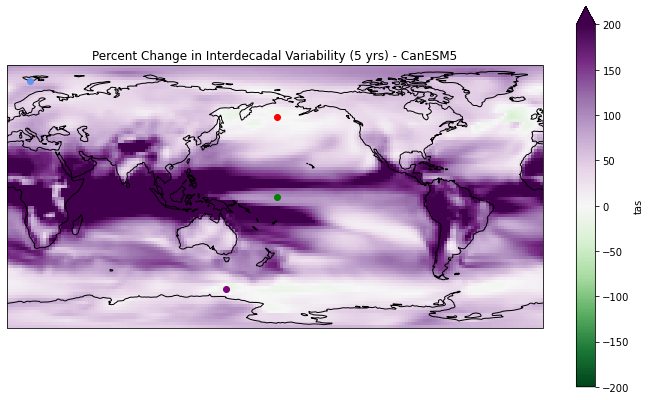

In [27]:
percent_5 = diff_5*100/summary_cont_5

plt.rcParams['figure.figsize'] = [12, 7]
font = {'size'   : 10}
matplotlib.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_5.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.plot(180,53, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(180,0, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(15,77, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(146,-62, marker='o', color='purple', transform=ccrs.PlateCarree())
plt.title('Percent Change in Interdecadal Variability (5 yrs) - CanESM5')

Text(0.5, 1.0, 'Control Interdecadal Variability (5 yrs) - CanESM5')

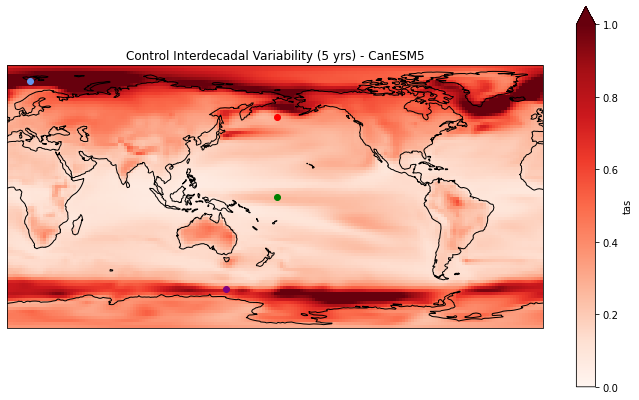

In [16]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
summary_cont_5.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)
plt.plot(180,53, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(180,0, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(15,77, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(146,-62, marker='o', color='purple', transform=ccrs.PlateCarree())
plt.title('Control Interdecadal Variability (5 yrs) - CanESM5')

Text(0.5, 1.0, 'Historical Interdecadal Variability (5 yrs) - CanESM5')

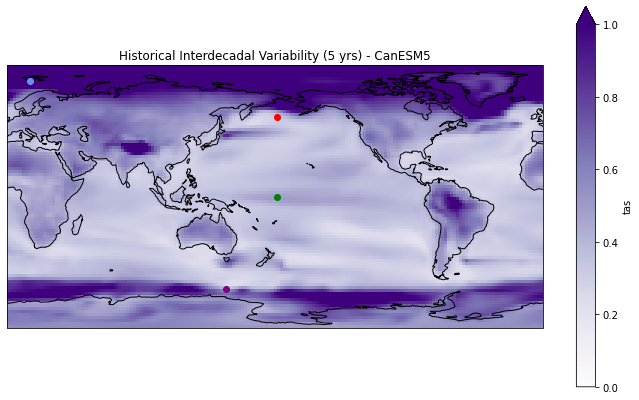

In [17]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
summary_hist_5.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Purples', vmin=0, vmax=1)
plt.plot(180,53, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(180,0, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(15,77, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(146,-62, marker='o', color='purple', transform=ccrs.PlateCarree())
ax.coastlines(color='black', linewidth=1)
plt.title('Historical Interdecadal Variability (5 yrs) - CanESM5')

In [18]:
cont_5yr_1 = canesm_5yr.sel(lat=53,method='nearest').sel(lon=180,method='nearest').isel(time=slice(300,1980))
hist_5yr_1 = canesm_hist_5yr.sel(lat=53,method='nearest').sel(lon=180,method='nearest').isel(time=slice(300,1980))

cont_5yr_2 = canesm_5yr.sel(lat=0,method='nearest').sel(lon=180,method='nearest').isel(time=slice(300,1980))
hist_5yr_2 = canesm_hist_5yr.sel(lat=0,method='nearest').sel(lon=180,method='nearest').isel(time=slice(300,1980))

cont_5yr_3 = canesm_5yr.sel(lat=77,method='nearest').sel(lon=15,method='nearest').isel(time=slice(300,1980))
hist_5yr_3 = canesm_hist_5yr.sel(lat=77,method='nearest').sel(lon=15,method='nearest').isel(time=slice(300,1980))

cont_5yr_4 = canesm_5yr.sel(lat=-62,method='nearest').sel(lon=146,method='nearest').isel(time=slice(300,1980))
hist_5yr_4 = canesm_hist_5yr.sel(lat=-62,method='nearest').sel(lon=146,method='nearest').isel(time=slice(300,1980))

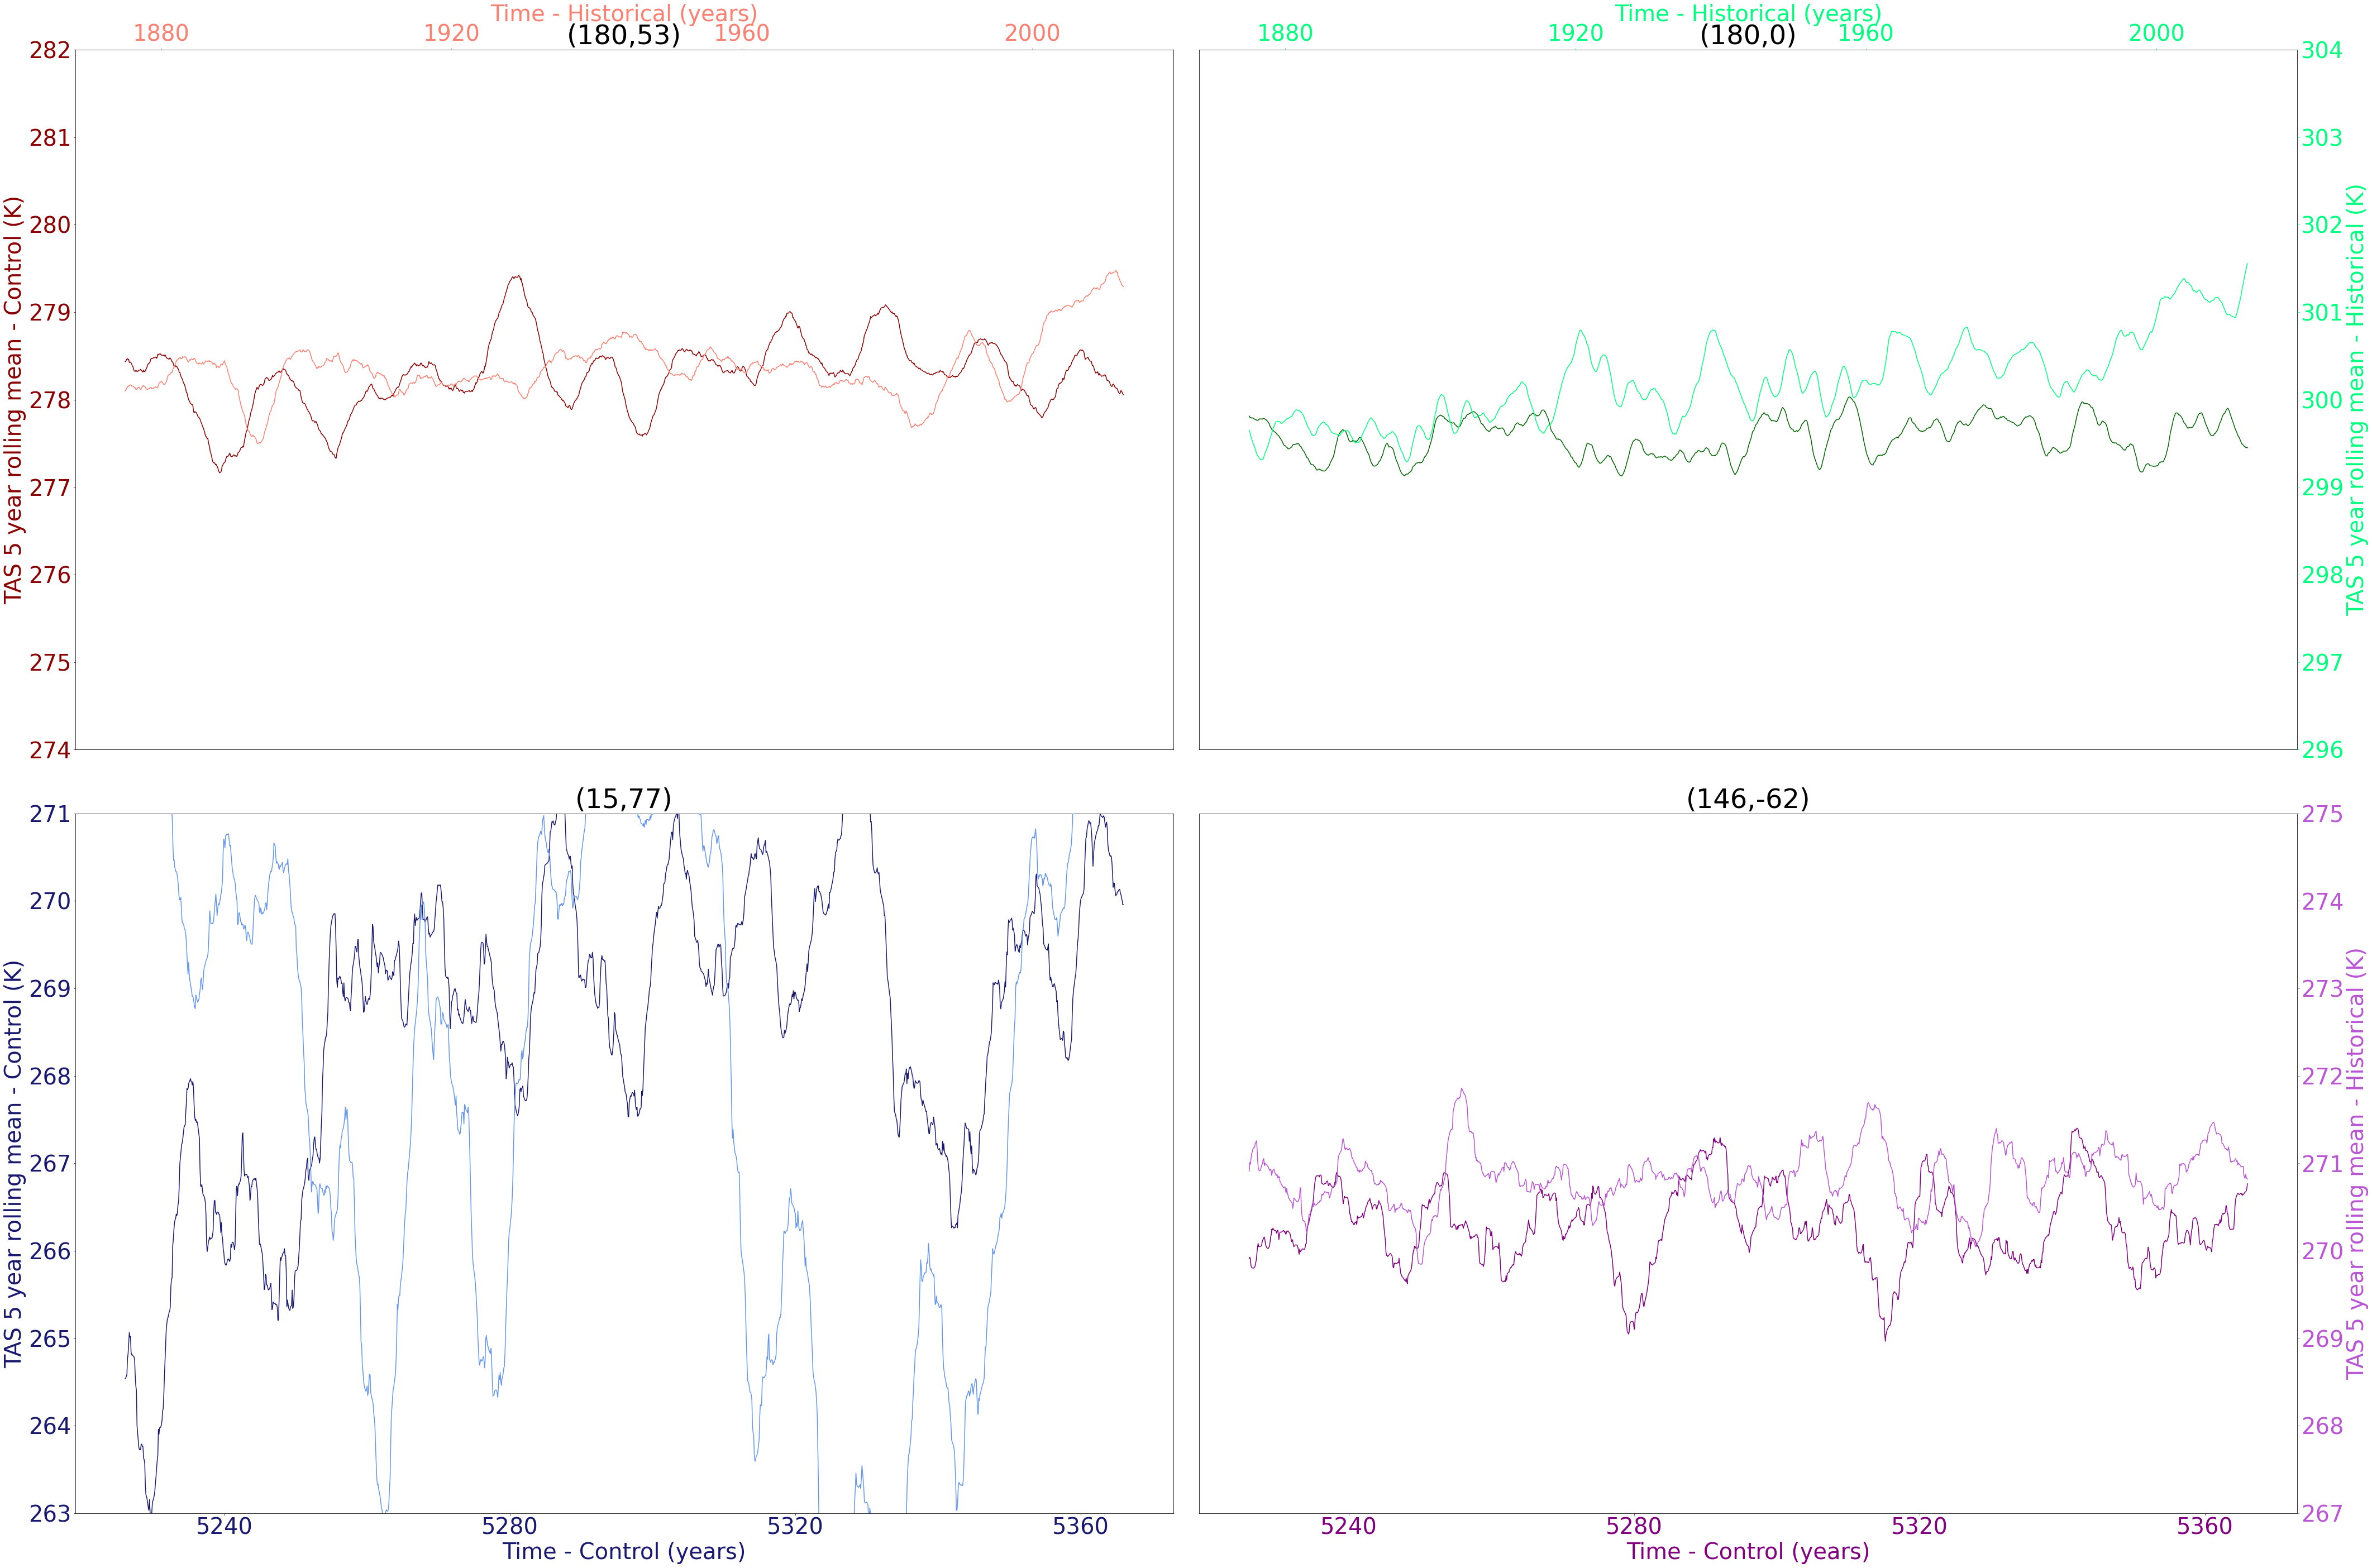

In [36]:
nrow = 1
ncol = 4
fig = plt.figure(figsize=(60, 40))
#grid = ImageGrid(fig, 
#                 111, # as in plt.subplot(111)
#                 nrows_ncols=(nrow,ncol),
#                 axes_pad=0,
#                 share_all=True,)

#for i in range(1):
#    for j in range(2):
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.1)
top=300
bottom=270
font = {'size'   : 40,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

#plt.subplot(gs[0,0])
ax = fig.add_subplot(221, label="Control")
ax2 = fig.add_subplot(221, label="Historical", frame_on=False)
ax.set_title('(180,53)')
ax.xaxis.set_visible(False)
ax.plot(cont_5yr_1['time'].values, cont_5yr_1, color="darkred")
ax.set_xlabel('Time - Control (years)', color="darkred")
ax.set_ylabel('TAS 5 year rolling mean - Control (K)', color="darkred")
ax.set_ylim(bottom=274,top=282)
ax.tick_params(axis='x', colors="darkred")
ax.tick_params(axis='y', colors="darkred")

ax2.plot(hist_5yr_1['time'].values, hist_5yr_1, color="salmon")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Time - Historical (years)', color="salmon") 
ax2.set_ylabel('TAS 5 year rolling mean - Historical (K)', color="salmon")  
ax2.set_ylim(top=282,bottom=274)
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_visible(False)
ax2.tick_params(axis='x', colors="salmon")
ax2.tick_params(axis='y', colors="salmon")

#plt.subplot(gs[0,1])
ax3 = fig.add_subplot(222, label="Control")
ax4 = fig.add_subplot(222, label="Historical", frame_on=False)
ax3.set_title('(180,0)')
ax3.yaxis.set_visible(False)
ax3.xaxis.set_visible(False)
ax3.plot(cont_5yr_2['time'].values, cont_5yr_2, color="darkgreen")
ax3.set_xlabel('Time - Control (years)', color="darkgreen")
ax3.set_ylabel('TAS 5 year rolling mean - Control (K)', color="darkgreen")
ax3.set_ylim(bottom=296,top=304)
ax3.tick_params(axis='x', colors="darkgreen")
ax3.tick_params(axis='y', colors="darkgreen")

ax4.plot(hist_5yr_2['time'].values, hist_5yr_2, color="springgreen")
ax4.xaxis.tick_top()
ax4.yaxis.tick_right()
#ax4.yaxis.set_visible(False)
ax4.set_xlabel('Time - Historical (years)', color="springgreen") 
ax4.set_ylabel('TAS 5 year rolling mean - Historical (K)', color="springgreen")  
ax4.set_ylim(top=304,bottom=296)
ax4.xaxis.set_label_position('top') 
ax4.yaxis.set_label_position('right') 
ax4.tick_params(axis='x', colors="springgreen")
ax4.tick_params(axis='y', colors="springgreen")

ax5 = fig.add_subplot(223, label="Control")
ax6 = fig.add_subplot(223, label="Historical", frame_on=False)
#ax5.yaxis.set_visible(False)
ax5.set_title('(15,77)')
ax5.plot(cont_5yr_3['time'].values, cont_5yr_3, color="midnightblue")
ax5.set_xlabel('Time - Control (years)', color="midnightblue")
ax5.set_ylabel('TAS 5 year rolling mean - Control (K)', color="midnightblue")
ax5.set_ylim(bottom=263,top=271)
ax5.tick_params(axis='x', colors="midnightblue")
ax5.tick_params(axis='y', colors="midnightblue")

ax6.plot(hist_5yr_3['time'].values, hist_5yr_3, color="cornflowerblue")
ax6.xaxis.tick_top()
ax6.yaxis.tick_right()
ax6.xaxis.set_visible(False)
ax6.yaxis.set_visible(False)
ax6.set_xlabel('Time - Historical (years)', color="cornflowerblue") 
ax6.set_ylabel('TAS 5 year rolling mean - Historical (K)', color="cornflowerblue")  
ax6.set_ylim(top=271,bottom=263)
ax6.xaxis.set_label_position('top') 
ax6.yaxis.set_label_position('right') 
ax6.tick_params(axis='x', colors="cornflowerblue")
ax6.tick_params(axis='y', colors="cornflowerblue")

ax7 = fig.add_subplot(224, label="Control")
ax8 = fig.add_subplot(224, label="Historical", frame_on=False)
ax7.yaxis.set_visible(False)
ax7.set_title('(146,-62)')
ax7.plot(cont_5yr_4['time'].values, cont_5yr_4, color="purple")
ax7.set_xlabel('Time - Control (years)', color="purple")
ax7.set_ylabel('TAS 5 year rolling mean - Control (K)', color="purple")
ax7.set_ylim(bottom=267,top=275)
ax7.tick_params(axis='x', colors="purple")
ax7.tick_params(axis='y', colors="purple")

ax8.plot(hist_5yr_4['time'].values, hist_5yr_4, color="mediumorchid")
ax8.xaxis.tick_top()
ax8.yaxis.tick_right()
ax8.xaxis.set_visible(False)
#ax8.yaxis.set_visible(False)
ax8.set_xlabel('Time - Historical (years)', color="mediumorchid") 
ax8.set_ylabel('TAS 5 year rolling mean - Historical (K)', color="mediumorchid")  
ax8.set_ylim(top=275,bottom=267)
ax8.xaxis.set_label_position('top') 
ax8.yaxis.set_label_position('right') 
ax8.tick_params(axis='x', colors="mediumorchid")
ax8.tick_params(axis='y', colors="mediumorchid")

# Get the current axis
ax = pylab.gca()

plt.tight_layout() # do not use this!!
plt.show()

# 15 year interval

In [20]:
canesm_15yr = canesm_control_ds.rolling(time=180, center=True).mean('time') #12*15 = 180
canesm_15yr.load()

<xarray.DataArray 'tas' (time: 21600, lat: 88, lon: 179)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    height   float64 2.0
  * time     (time) object 5201-01-16 12:00:00 ... 6200-12-16 12:00:00
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        ST+273.16, CMIP_table_comment: near-surface (usually, 2 m...
    long_name:      Near-Surface Air Temperature
    original_name:  ST
    standard_name:  air_temperature
    units:          K

In [21]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

canesm_hist_ds = xr.open_dataset(path_canesm_hist)
canesm_hist_15yr = canesm_hist_ds.tas.interp(lat=new_lats,lon=new_lons).rolling(time=180, center=True).mean('time')
#canesm_hist = canesm_hist_ds.tas.rolling(time=300, center=True).mean('time')
canesm_hist_15yr.load()

<xarray.DataArray 'tas' (time: 1980, lat: 88, lon: 179)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    height   float64 2.0
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        ST+273.16, CMIP_table_comment: near-surface (usually, 2 m...
    history:        degctok 2019-04-30T17:40:12Z altered by CMOR: Treated sca...
    long_name:      Near-Surface Air Temperature
    original_name:  ST
    standard_name:  air_temperature
    units:          K

In [22]:
summary_cont_15 = canesm_15yr.std('time')
summary_cont_15.load()
summary_hist_15 = canesm_hist_15yr.std('time')
summary_hist_15.load()

<xarray.DataArray 'tas' (lat: 88, lon: 179)>
array([[0.42693656, 0.42862708, 0.43030713, ..., 0.42050899, 0.42209504,
        0.42356373],
       [0.44621986, 0.44992952, 0.45320136, ..., 0.43276667, 0.43613114,
        0.43931765],
       [0.46425375, 0.46635219, 0.46656725, ..., 0.44394339, 0.4501705 ,
        0.45550801],
       ...,
       [1.11079677, 1.11743868, 1.12484559, ..., 1.05928535, 1.07652119,
        1.09163182],
       [1.08924065, 1.09572262, 1.10100465, ..., 1.04984311, 1.06215675,
        1.07325412],
       [0.97131712, 0.97383746, 0.97567466, ..., 0.95472088, 0.95967402,
        0.9644899 ]])
Coordinates:
    height   float64 2.0
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

Text(0.5, 1.0, 'Change in Interdecadal Variability (15 yrs) - CanESM5')

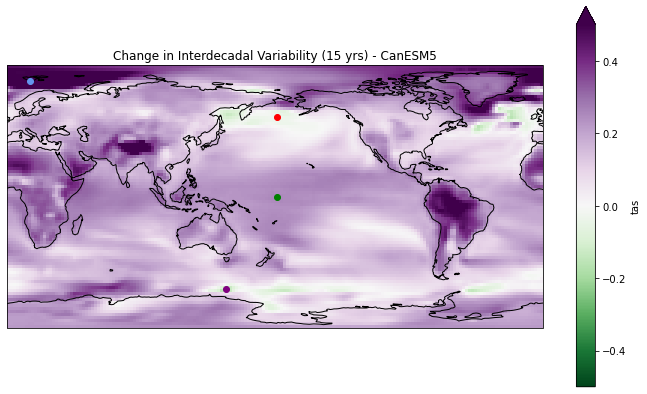

In [25]:
diff_15 = summary_hist_15 - summary_cont_15

plt.rcParams['figure.figsize'] = [12, 7]
font = {'size'   : 10}
matplotlib.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
diff_15.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.plot(180,53, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(180,0, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(15,77, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(146,-62, marker='o', color='purple', transform=ccrs.PlateCarree())
plt.title('Change in Interdecadal Variability (15 yrs) - CanESM5')

Text(0.5, 1.0, 'Percent Change in Interdecadal Variability (15 yrs) - CanESM5')

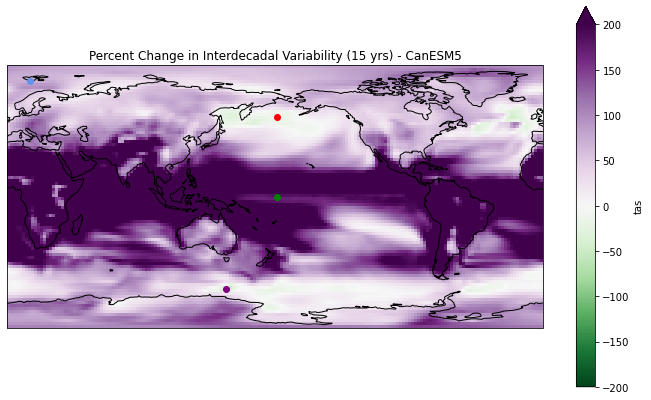

In [26]:
percent_15 = diff_15*100/summary_cont_15

plt.rcParams['figure.figsize'] = [12, 7]
font = {'size'   : 10}
matplotlib.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_15.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.plot(180,53, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(180,0, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(15,77, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(146,-62, marker='o', color='purple', transform=ccrs.PlateCarree())
plt.title('Percent Change in Interdecadal Variability (15 yrs) - CanESM5')

Text(0.5, 1.0, 'Control Interdecadal Variability (15 yrs) - CanESM5')

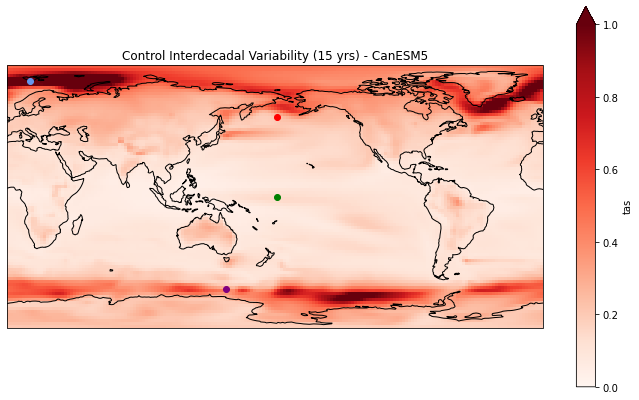

In [29]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
summary_cont_15.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)
plt.plot(180,53, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(180,0, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(15,77, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(146,-62, marker='o', color='purple', transform=ccrs.PlateCarree())
plt.title('Control Interdecadal Variability (15 yrs) - CanESM5')

Text(0.5, 1.0, 'Historical Interdecadal Variability (15 yrs) - CanESM5')

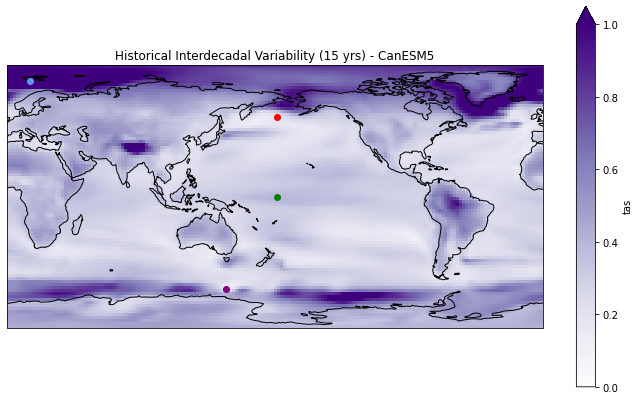

In [30]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
summary_hist_15.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Purples', vmin=0, vmax=1)
plt.plot(180,53, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(180,0, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(15,77, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(146,-62, marker='o', color='purple', transform=ccrs.PlateCarree())
ax.coastlines(color='black', linewidth=1)
plt.title('Historical Interdecadal Variability (15 yrs) - CanESM5')

In [33]:
cont_15yr_1 = canesm_15yr.sel(lat=53,method='nearest').sel(lon=180,method='nearest').isel(time=slice(300,1980))
hist_15yr_1 = canesm_hist_15yr.sel(lat=53,method='nearest').sel(lon=180,method='nearest').isel(time=slice(300,1980))

cont_15yr_2 = canesm_15yr.sel(lat=0,method='nearest').sel(lon=180,method='nearest').isel(time=slice(300,1980))
hist_15yr_2 = canesm_hist_15yr.sel(lat=0,method='nearest').sel(lon=180,method='nearest').isel(time=slice(300,1980))

cont_15yr_3 = canesm_15yr.sel(lat=77,method='nearest').sel(lon=15,method='nearest').isel(time=slice(300,1980))
hist_15yr_3 = canesm_hist_15yr.sel(lat=77,method='nearest').sel(lon=15,method='nearest').isel(time=slice(300,1980))

cont_15yr_4 = canesm_15yr.sel(lat=-62,method='nearest').sel(lon=146,method='nearest').isel(time=slice(300,1980))
hist_15yr_4 = canesm_hist_15yr.sel(lat=-62,method='nearest').sel(lon=146,method='nearest').isel(time=slice(300,1980))

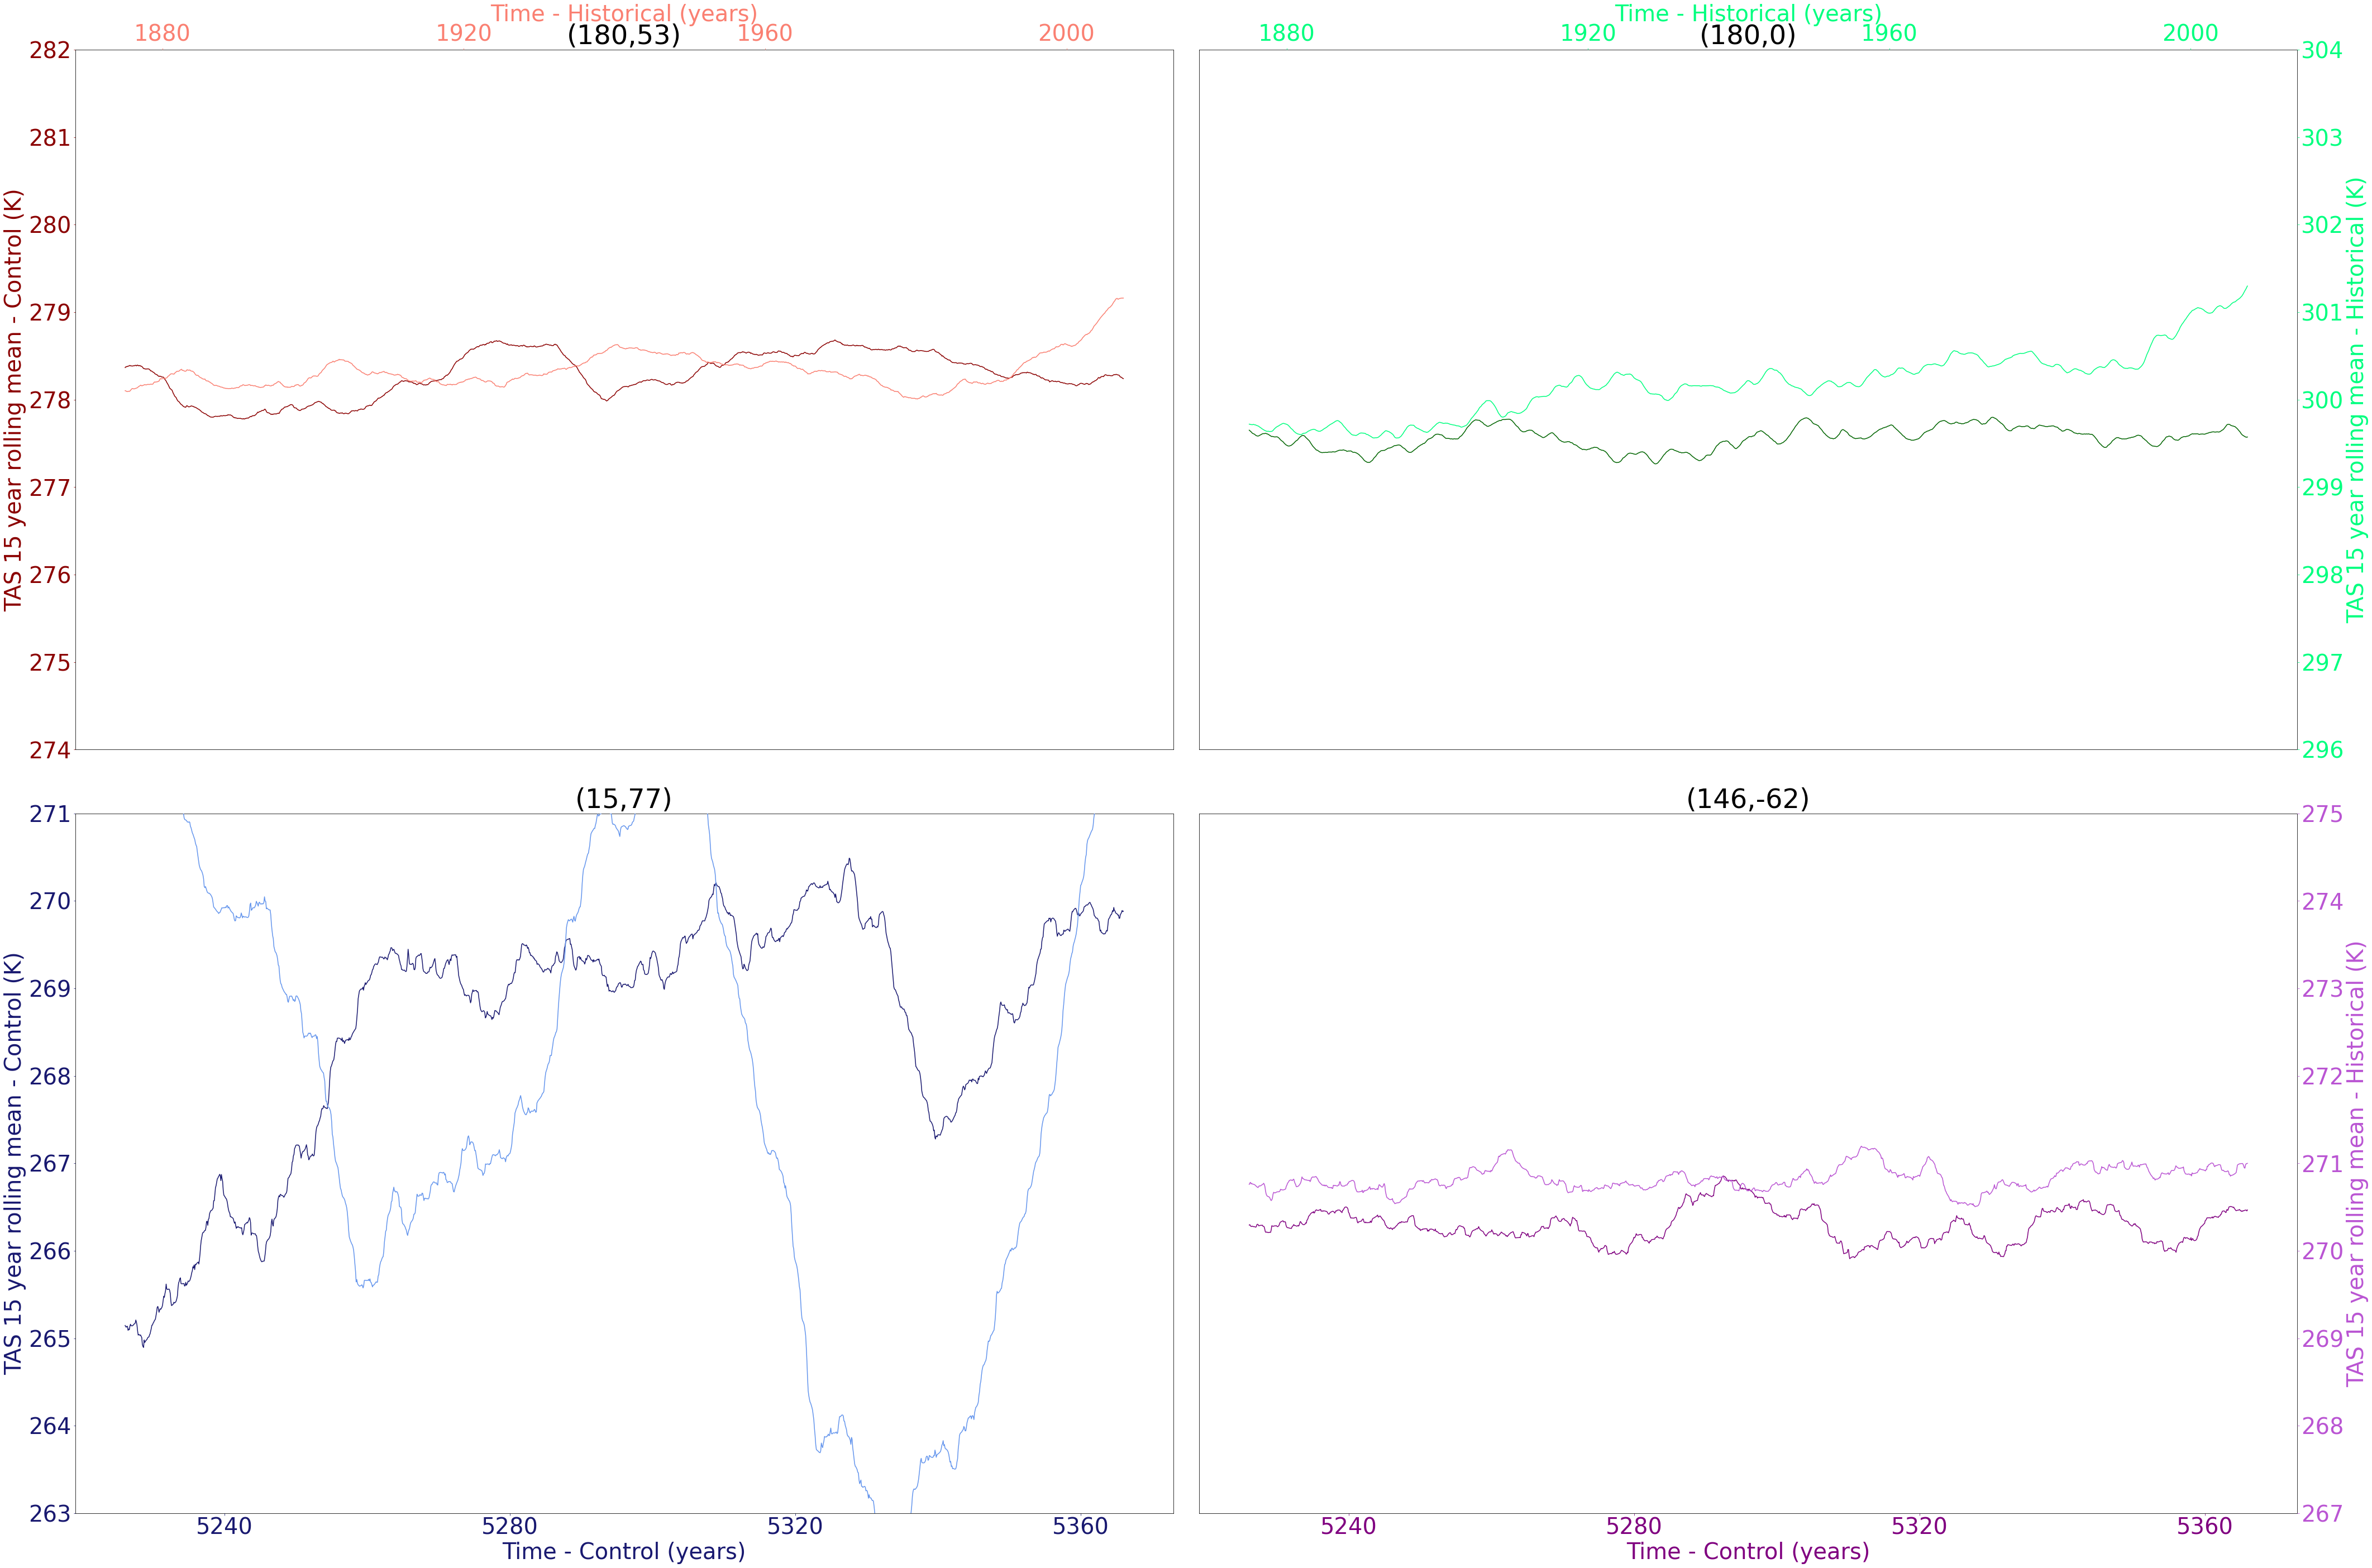

In [35]:
nrow = 1
ncol = 4
fig = plt.figure(figsize=(60, 40))
#grid = ImageGrid(fig, 
#                 111, # as in plt.subplot(111)
#                 nrows_ncols=(nrow,ncol),
#                 axes_pad=0,
#                 share_all=True,)

#for i in range(1):
#    for j in range(2):
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.1)
top=300
bottom=270
font = {'size'   : 40,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

#plt.subplot(gs[0,0])
ax = fig.add_subplot(221, label="Control")
ax2 = fig.add_subplot(221, label="Historical", frame_on=False)
ax.set_title('(180,53)')
ax.xaxis.set_visible(False)
ax.plot(cont_15yr_1['time'].values, cont_15yr_1, color="darkred")
ax.set_xlabel('Time - Control (years)', color="darkred")
ax.set_ylabel('TAS 15 year rolling mean - Control (K)', color="darkred")
ax.set_ylim(bottom=274,top=282)
ax.tick_params(axis='x', colors="darkred")
ax.tick_params(axis='y', colors="darkred")

ax2.plot(hist_15yr_1['time'].values, hist_15yr_1, color="salmon")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Time - Historical (years)', color="salmon") 
ax2.set_ylabel('TAS 15 year rolling mean - Historical (K)', color="salmon")  
ax2.set_ylim(top=282,bottom=274)
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_visible(False)
ax2.tick_params(axis='x', colors="salmon")
ax2.tick_params(axis='y', colors="salmon")

#plt.subplot(gs[0,1])
ax3 = fig.add_subplot(222, label="Control")
ax4 = fig.add_subplot(222, label="Historical", frame_on=False)
ax3.set_title('(180,0)')
ax3.yaxis.set_visible(False)
ax3.xaxis.set_visible(False)
ax3.plot(cont_15yr_2['time'].values, cont_15yr_2, color="darkgreen")
ax3.set_xlabel('Time - Control (years)', color="darkgreen")
ax3.set_ylabel('TAS 15 year rolling mean - Control (K)', color="darkgreen")
ax3.set_ylim(bottom=296,top=304)
ax3.tick_params(axis='x', colors="darkgreen")
ax3.tick_params(axis='y', colors="darkgreen")

ax4.plot(hist_15yr_2['time'].values, hist_15yr_2, color="springgreen")
ax4.xaxis.tick_top()
ax4.yaxis.tick_right()
#ax4.yaxis.set_visible(False)
ax4.set_xlabel('Time - Historical (years)', color="springgreen") 
ax4.set_ylabel('TAS 15 year rolling mean - Historical (K)', color="springgreen")  
ax4.set_ylim(top=304,bottom=296)
ax4.xaxis.set_label_position('top') 
ax4.yaxis.set_label_position('right') 
ax4.tick_params(axis='x', colors="springgreen")
ax4.tick_params(axis='y', colors="springgreen")

ax5 = fig.add_subplot(223, label="Control")
ax6 = fig.add_subplot(223, label="Historical", frame_on=False)
#ax5.yaxis.set_visible(False)
ax5.set_title('(15,77)')
ax5.plot(cont_15yr_3['time'].values, cont_15yr_3, color="midnightblue")
ax5.set_xlabel('Time - Control (years)', color="midnightblue")
ax5.set_ylabel('TAS 15 year rolling mean - Control (K)', color="midnightblue")
ax5.set_ylim(bottom=263,top=271)
ax5.tick_params(axis='x', colors="midnightblue")
ax5.tick_params(axis='y', colors="midnightblue")

ax6.plot(hist_15yr_3['time'].values, hist_15yr_3, color="cornflowerblue")
ax6.xaxis.tick_top()
ax6.yaxis.tick_right()
ax6.xaxis.set_visible(False)
ax6.yaxis.set_visible(False)
ax6.set_xlabel('Time - Historical (years)', color="cornflowerblue") 
ax6.set_ylabel('TAS 15 year rolling mean - Historical (K)', color="cornflowerblue")  
ax6.set_ylim(top=271,bottom=263)
ax6.xaxis.set_label_position('top') 
ax6.yaxis.set_label_position('right') 
ax6.tick_params(axis='x', colors="cornflowerblue")
ax6.tick_params(axis='y', colors="cornflowerblue")

ax7 = fig.add_subplot(224, label="Control")
ax8 = fig.add_subplot(224, label="Historical", frame_on=False)
ax7.yaxis.set_visible(False)
ax7.set_title('(146,-62)')
ax7.plot(cont_15yr_4['time'].values, cont_15yr_4, color="purple")
ax7.set_xlabel('Time - Control (years)', color="purple")
ax7.set_ylabel('TAS 15 year rolling mean - Control (K)', color="purple")
ax7.set_ylim(bottom=267,top=275)
ax7.tick_params(axis='x', colors="purple")
ax7.tick_params(axis='y', colors="purple")

ax8.plot(hist_15yr_4['time'].values, hist_15yr_4, color="mediumorchid")
ax8.xaxis.tick_top()
ax8.yaxis.tick_right()
ax8.xaxis.set_visible(False)
#ax8.yaxis.set_visible(False)
ax8.set_xlabel('Time - Historical (years)', color="mediumorchid") 
ax8.set_ylabel('TAS 15 year rolling mean - Historical (K)', color="mediumorchid")  
ax8.set_ylim(top=275,bottom=267)
ax8.xaxis.set_label_position('top') 
ax8.yaxis.set_label_position('right') 
ax8.tick_params(axis='x', colors="mediumorchid")
ax8.tick_params(axis='y', colors="mediumorchid")

# Get the current axis
ax = pylab.gca()

plt.tight_layout() # do not use this!!
plt.show()

# HADGEM3-GC31-LL

In [4]:
path_hadgem_control = cat.loc[(cat['variable_id']=='tas') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control')) &
               (cat['source_id']=='HadGEM3-GC31-LL') &
               (cat['variant_label']=='r1i1p1f1')]['path'].to_list()
path_hadgem_control = path_hadgem_control[0]
path_hadgem_control

'/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-LL/piControl/r1i1p1f1/tas_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc'

In [5]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

hadgem_control_ds = xr.open_dataset(path_hadgem_control)
hadgem_control = hadgem_control_ds.tas.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
hadgem_control.load()

<xarray.DataArray 'tas' (time: 6000, lat: 88, lon: 179)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    height   float64 1.5
  * time     (time) object 1850-01-16 00:00:00 ... 2349-12-16 00:00:00
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    long_name:      Near-Surface Air Temperature
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    standard_name:  air_temperature
    units:          K

In [6]:
path_hadgem_hist = cat.loc[(cat['variable_id']=='tas') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id']=='historical') &
               (cat['source_id']=='HadGEM3-GC31-LL')].head(5)['path'].to_list()
path_hadgem_hist = path_hadgem_hist[0]
path_hadgem_hist

'/data/cristi/a/cristi/esm_data/cmip6/HadGEM3-GC31-LL/historical/r1i1p1f3/tas_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_185001-201412.nc'

In [7]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

hadgem_hist_ds = xr.open_dataset(path_hadgem_hist)
hadgem_hist = hadgem_hist_ds.tas.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
hadgem_hist.load()

<xarray.DataArray 'tas' (time: 1980, lat: 88, lon: 179)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    height   float64 1.5
  * time     (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    long_name:      Near-Surface Air Temperature
    original_name:  mo: (stash: m01s03i236, lbproc: 128)
    standard_name:  air_temperature
    units:          K

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - HadGEM3')

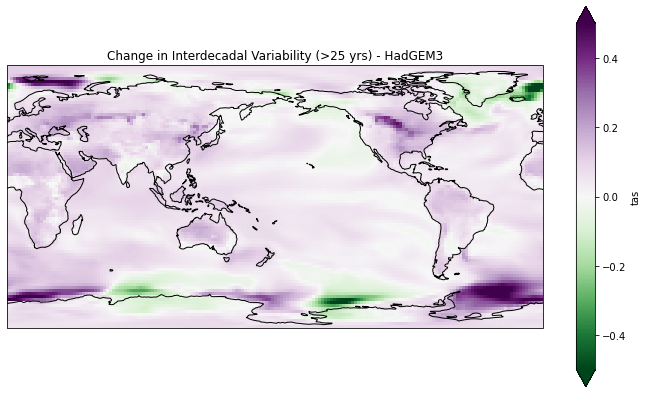

In [8]:
hadgem_hist_summary = hadgem_hist.std('time')
hadgem_hist_summary.load()
hadgem_cont_summary = hadgem_control.std('time')
hadgem_cont_summary.load()

delta_hadgem = hadgem_hist_summary - hadgem_cont_summary

plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
delta_hadgem.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.title('Change in Interdecadal Variability (>25 yrs) - HadGEM3')

Text(0.5, 1.0, 'Percent Change in Interdecadal Variability (>25 yrs) - HadGEM3')

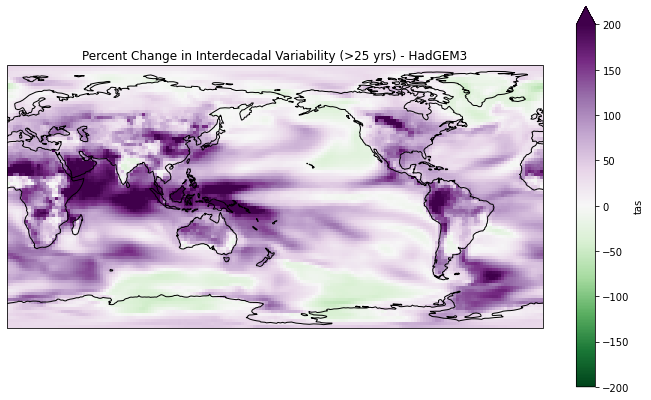

In [14]:
percent_hadgem = ((delta_hadgem)/hadgem_cont_summary)*100

plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_hadgem.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.title('Percent Change in Interdecadal Variability (>25 yrs) - HadGEM3')

# (321,-63)

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - HadGEM3')

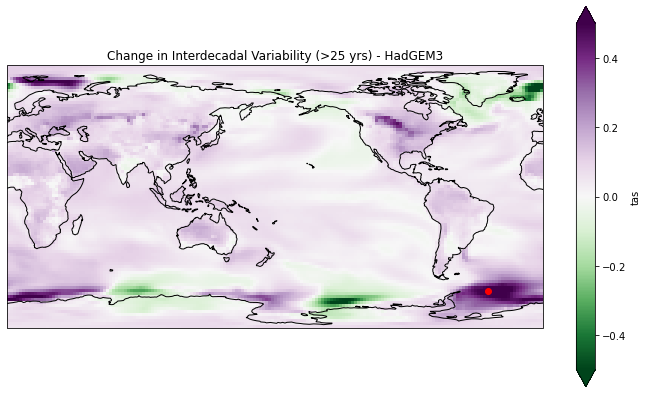

In [23]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
delta_hadgem.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.plot(321,-63, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Change in Interdecadal Variability (>25 yrs) - HadGEM3')

Text(0.5, 1.0, 'Percent Change in Interdecadal Variability (>25 yrs) - HadGEM3')

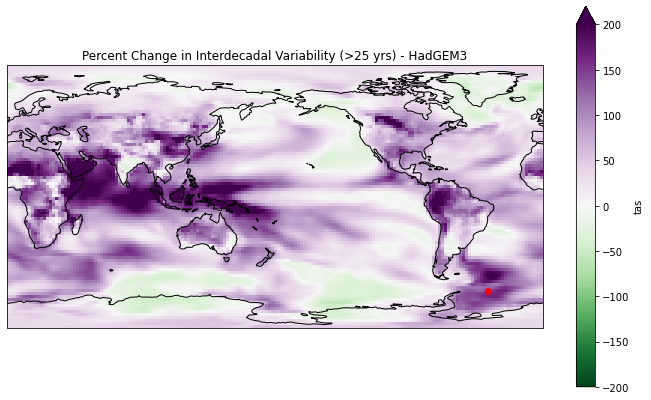

In [22]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_hadgem.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.plot(321,-63, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Percent Change in Interdecadal Variability (>25 yrs) - HadGEM3')

In [20]:
time_series_cont_hadgem1 = hadgem_control.sel(lat=-63,method='nearest').sel(lon=321,method='nearest').isel(time=slice(300,1980))
time_series_hist_hadgem1 = hadgem_hist.sel(lat=-63,method='nearest').sel(lon=321,method='nearest').isel(time=slice(300,1980))

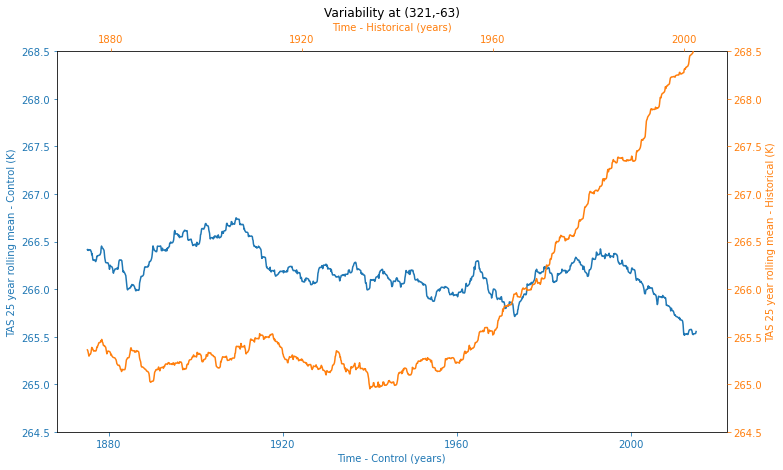

In [35]:
# https://stackoverflow.com/questions/42734109/two-or-more-graphs-in-one-plot-with-different-x-axis-and-y-axis-scales-in-pyth
fig = plt.figure()
ax = fig.add_subplot(111, label="Control")
ax2 = fig.add_subplot(111, label="Historical", frame_on=False)

plt.title('Variability at (321,-63)')
ax.plot(time_series_cont_hadgem1['time'].values,time_series_cont_hadgem1, color="C0")
ax.set_xlabel('Time - Control (years)', color="C0")
ax.set_ylabel('TAS 25 year rolling mean - Control (K)', color="C0")
ax.set_ylim(bottom=264.5,top=268.5)
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.plot(time_series_hist_hadgem1['time'].values,time_series_hist_hadgem1, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Time - Historical (years)', color="C1") 
ax2.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="C1")  
ax2.set_ylim(top=268.5,bottom=264.5)
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")

# (220,-69)

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - HadGEM3')

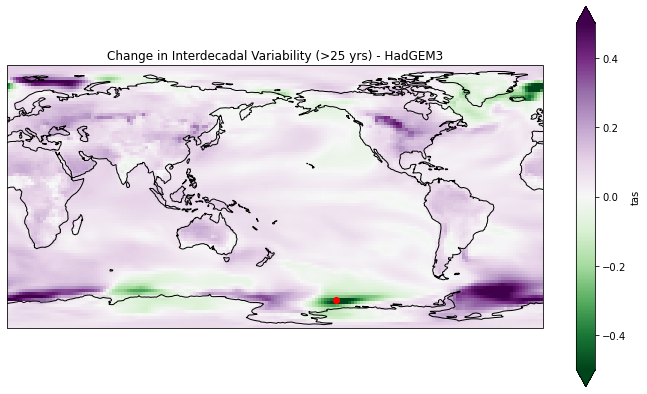

In [73]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
delta_hadgem.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.plot(220,-69, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Change in Interdecadal Variability (>25 yrs) - HadGEM3')

Text(0.5, 1.0, 'Percent Change in Interdecadal Variability (>25 yrs) - HadGEM3')

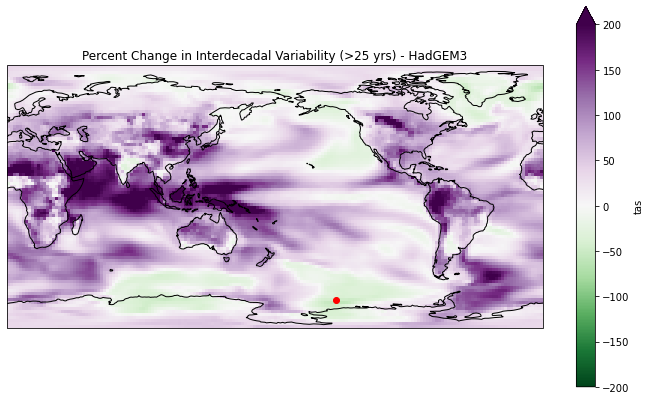

In [74]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_hadgem.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.plot(220,-69, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Percent Change in Interdecadal Variability (>25 yrs) - HadGEM3')

In [75]:
time_series_cont_hadgem2 = hadgem_control.sel(lat=-69,method='nearest').sel(lon=220,method='nearest').isel(time=slice(300,1980))
time_series_hist_hadgem2 = hadgem_hist.sel(lat=-69,method='nearest').sel(lon=220,method='nearest').isel(time=slice(300,1980))

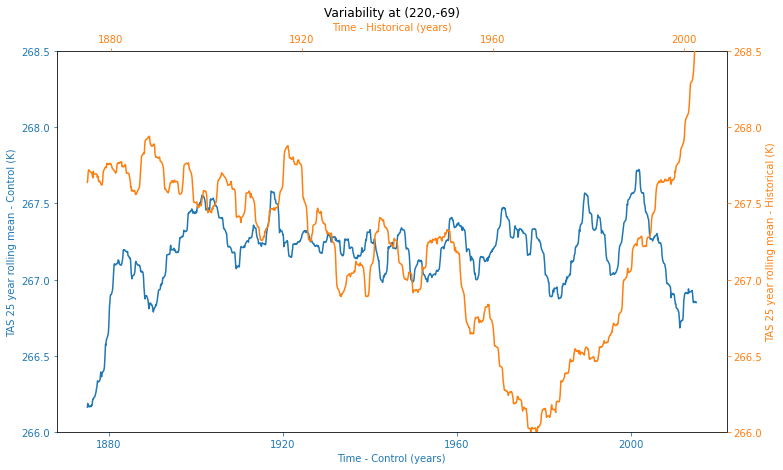

In [77]:
# https://stackoverflow.com/questions/42734109/two-or-more-graphs-in-one-plot-with-different-x-axis-and-y-axis-scales-in-pyth
fig = plt.figure()
ax = fig.add_subplot(111, label="Control")
ax2 = fig.add_subplot(111, label="Historical", frame_on=False)

plt.title('Variability at (220,-69)')
ax.plot(time_series_cont_hadgem2['time'].values,time_series_cont_hadgem2, color="C0")
ax.set_xlabel('Time - Control (years)', color="C0")
ax.set_ylabel('TAS 25 year rolling mean - Control (K)', color="C0")
ax.set_ylim(bottom=266,top=268.5)
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.plot(time_series_hist_hadgem2['time'].values,time_series_hist_hadgem2, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Time - Historical (years)', color="C1") 
ax2.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="C1")  
ax2.set_ylim(top=268.5,bottom=266)
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")

# (257,15)

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - HadGEM3')

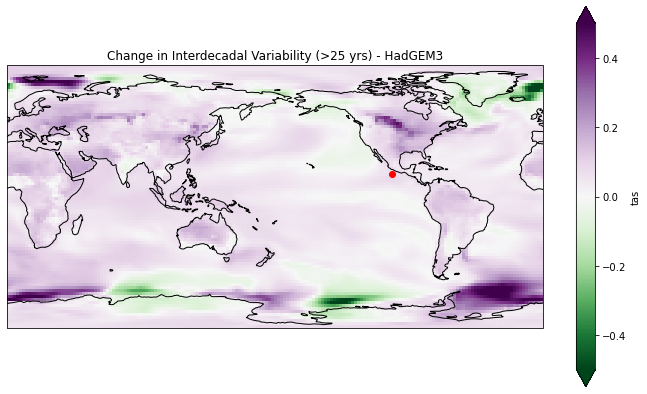

In [55]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
delta_hadgem.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.plot(257,15, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Change in Interdecadal Variability (>25 yrs) - HadGEM3')

Text(0.5, 1.0, 'Percent Change in Interdecadal Variability (>25 yrs) - HadGEM3')

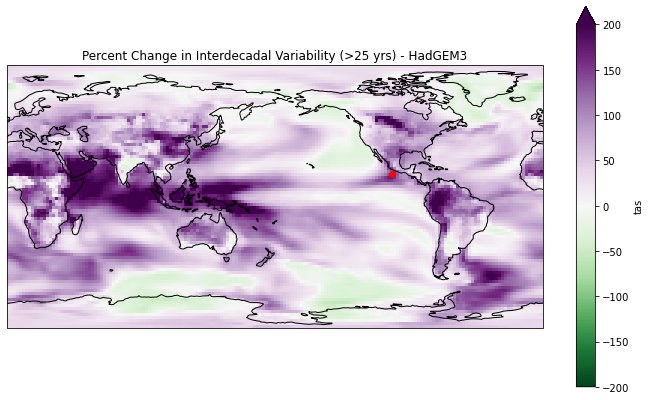

In [54]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_hadgem.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.plot(257,15, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Percent Change in Interdecadal Variability (>25 yrs) - HadGEM3')

In [56]:
time_series_cont_hadgem3 = hadgem_control.sel(lat=15,method='nearest').sel(lon=257,method='nearest').isel(time=slice(300,1980))
time_series_hist_hadgem3 = hadgem_hist.sel(lat=15,method='nearest').sel(lon=257,method='nearest').isel(time=slice(300,1980))

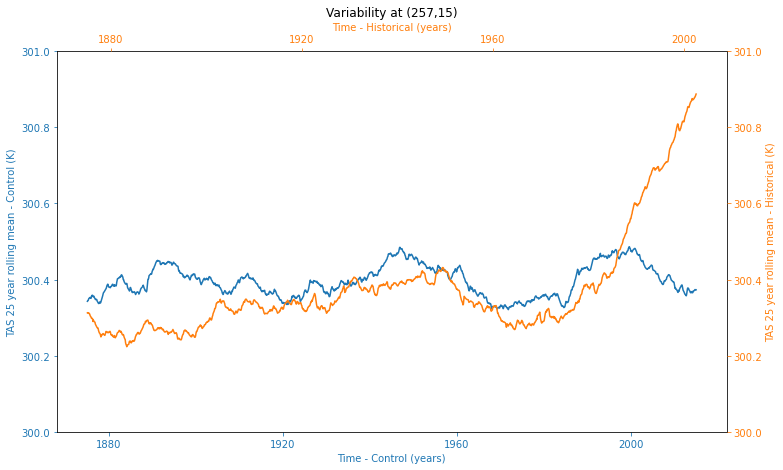

In [59]:
# https://stackoverflow.com/questions/42734109/two-or-more-graphs-in-one-plot-with-different-x-axis-and-y-axis-scales-in-pyth
fig = plt.figure()
ax = fig.add_subplot(111, label="Control")
ax2 = fig.add_subplot(111, label="Historical", frame_on=False)

plt.title('Variability at (257,15)')
ax.plot(time_series_cont_hadgem3['time'].values,time_series_cont_hadgem3, color="C0")
ax.set_xlabel('Time - Control (years)', color="C0")
ax.set_ylabel('TAS 25 year rolling mean - Control (K)', color="C0")
ax.set_ylim(bottom=300,top=301)
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.plot(time_series_hist_hadgem3['time'].values,time_series_hist_hadgem3, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Time - Historical (years)', color="C1") 
ax2.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="C1")  
ax2.set_ylim(top=301,bottom=300)
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")

# (354,73)

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - HadGEM3')

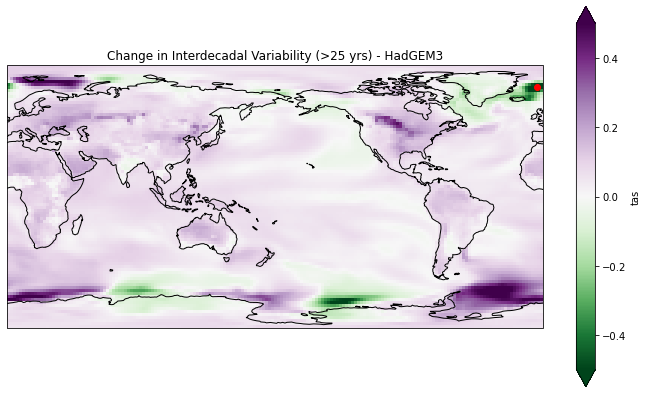

In [62]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
delta_hadgem.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.plot(354,73, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Change in Interdecadal Variability (>25 yrs) - HadGEM3')

Text(0.5, 1.0, 'Percent Change in Interdecadal Variability (>25 yrs) - HadGEM3')

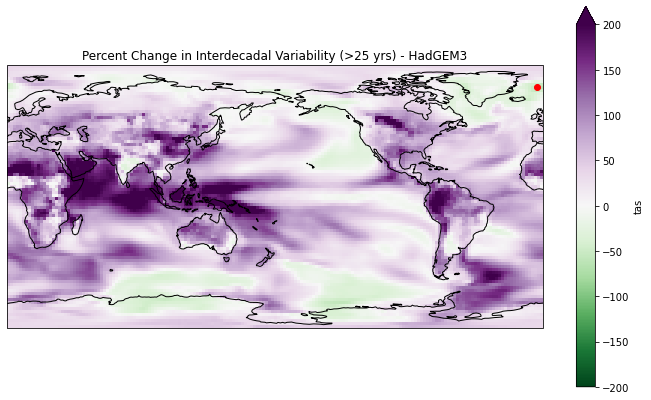

In [64]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_hadgem.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.plot(354,73, marker='o', color='r', transform=ccrs.PlateCarree())
plt.title('Percent Change in Interdecadal Variability (>25 yrs) - HadGEM3')

In [65]:
time_series_cont_hadgem4 = hadgem_control.sel(lat=73,method='nearest').sel(lon=354,method='nearest').isel(time=slice(300,1980))
time_series_hist_hadgem4 = hadgem_hist.sel(lat=73,method='nearest').sel(lon=354,method='nearest').isel(time=slice(300,1980))

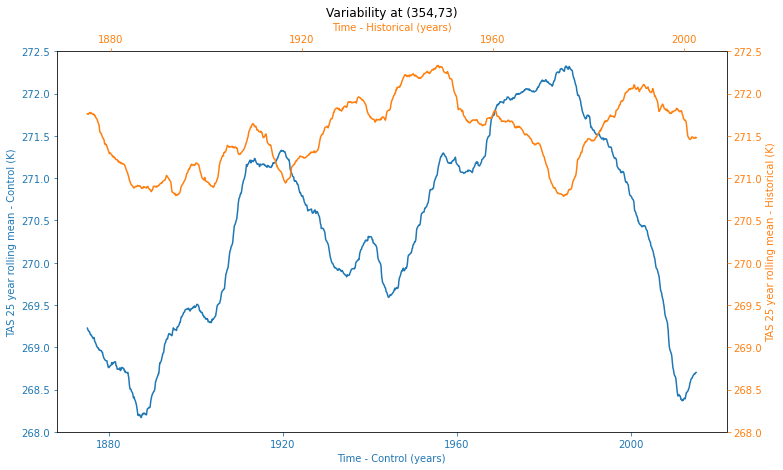

In [68]:
# https://stackoverflow.com/questions/42734109/two-or-more-graphs-in-one-plot-with-different-x-axis-and-y-axis-scales-in-pyth
fig = plt.figure()
ax = fig.add_subplot(111, label="Control")
ax2 = fig.add_subplot(111, label="Historical", frame_on=False)

plt.title('Variability at (354,73)')
ax.plot(time_series_cont_hadgem4['time'].values,time_series_cont_hadgem4, color="C0")
ax.set_xlabel('Time - Control (years)', color="C0")
ax.set_ylabel('TAS 25 year rolling mean - Control (K)', color="C0")
ax.set_ylim(bottom=268,top=272.5)
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.plot(time_series_hist_hadgem4['time'].values,time_series_hist_hadgem4, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Time - Historical (years)', color="C1") 
ax2.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="C1")  
ax2.set_ylim(top=272.5,bottom=268)
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")

# HadGEM3 - All together

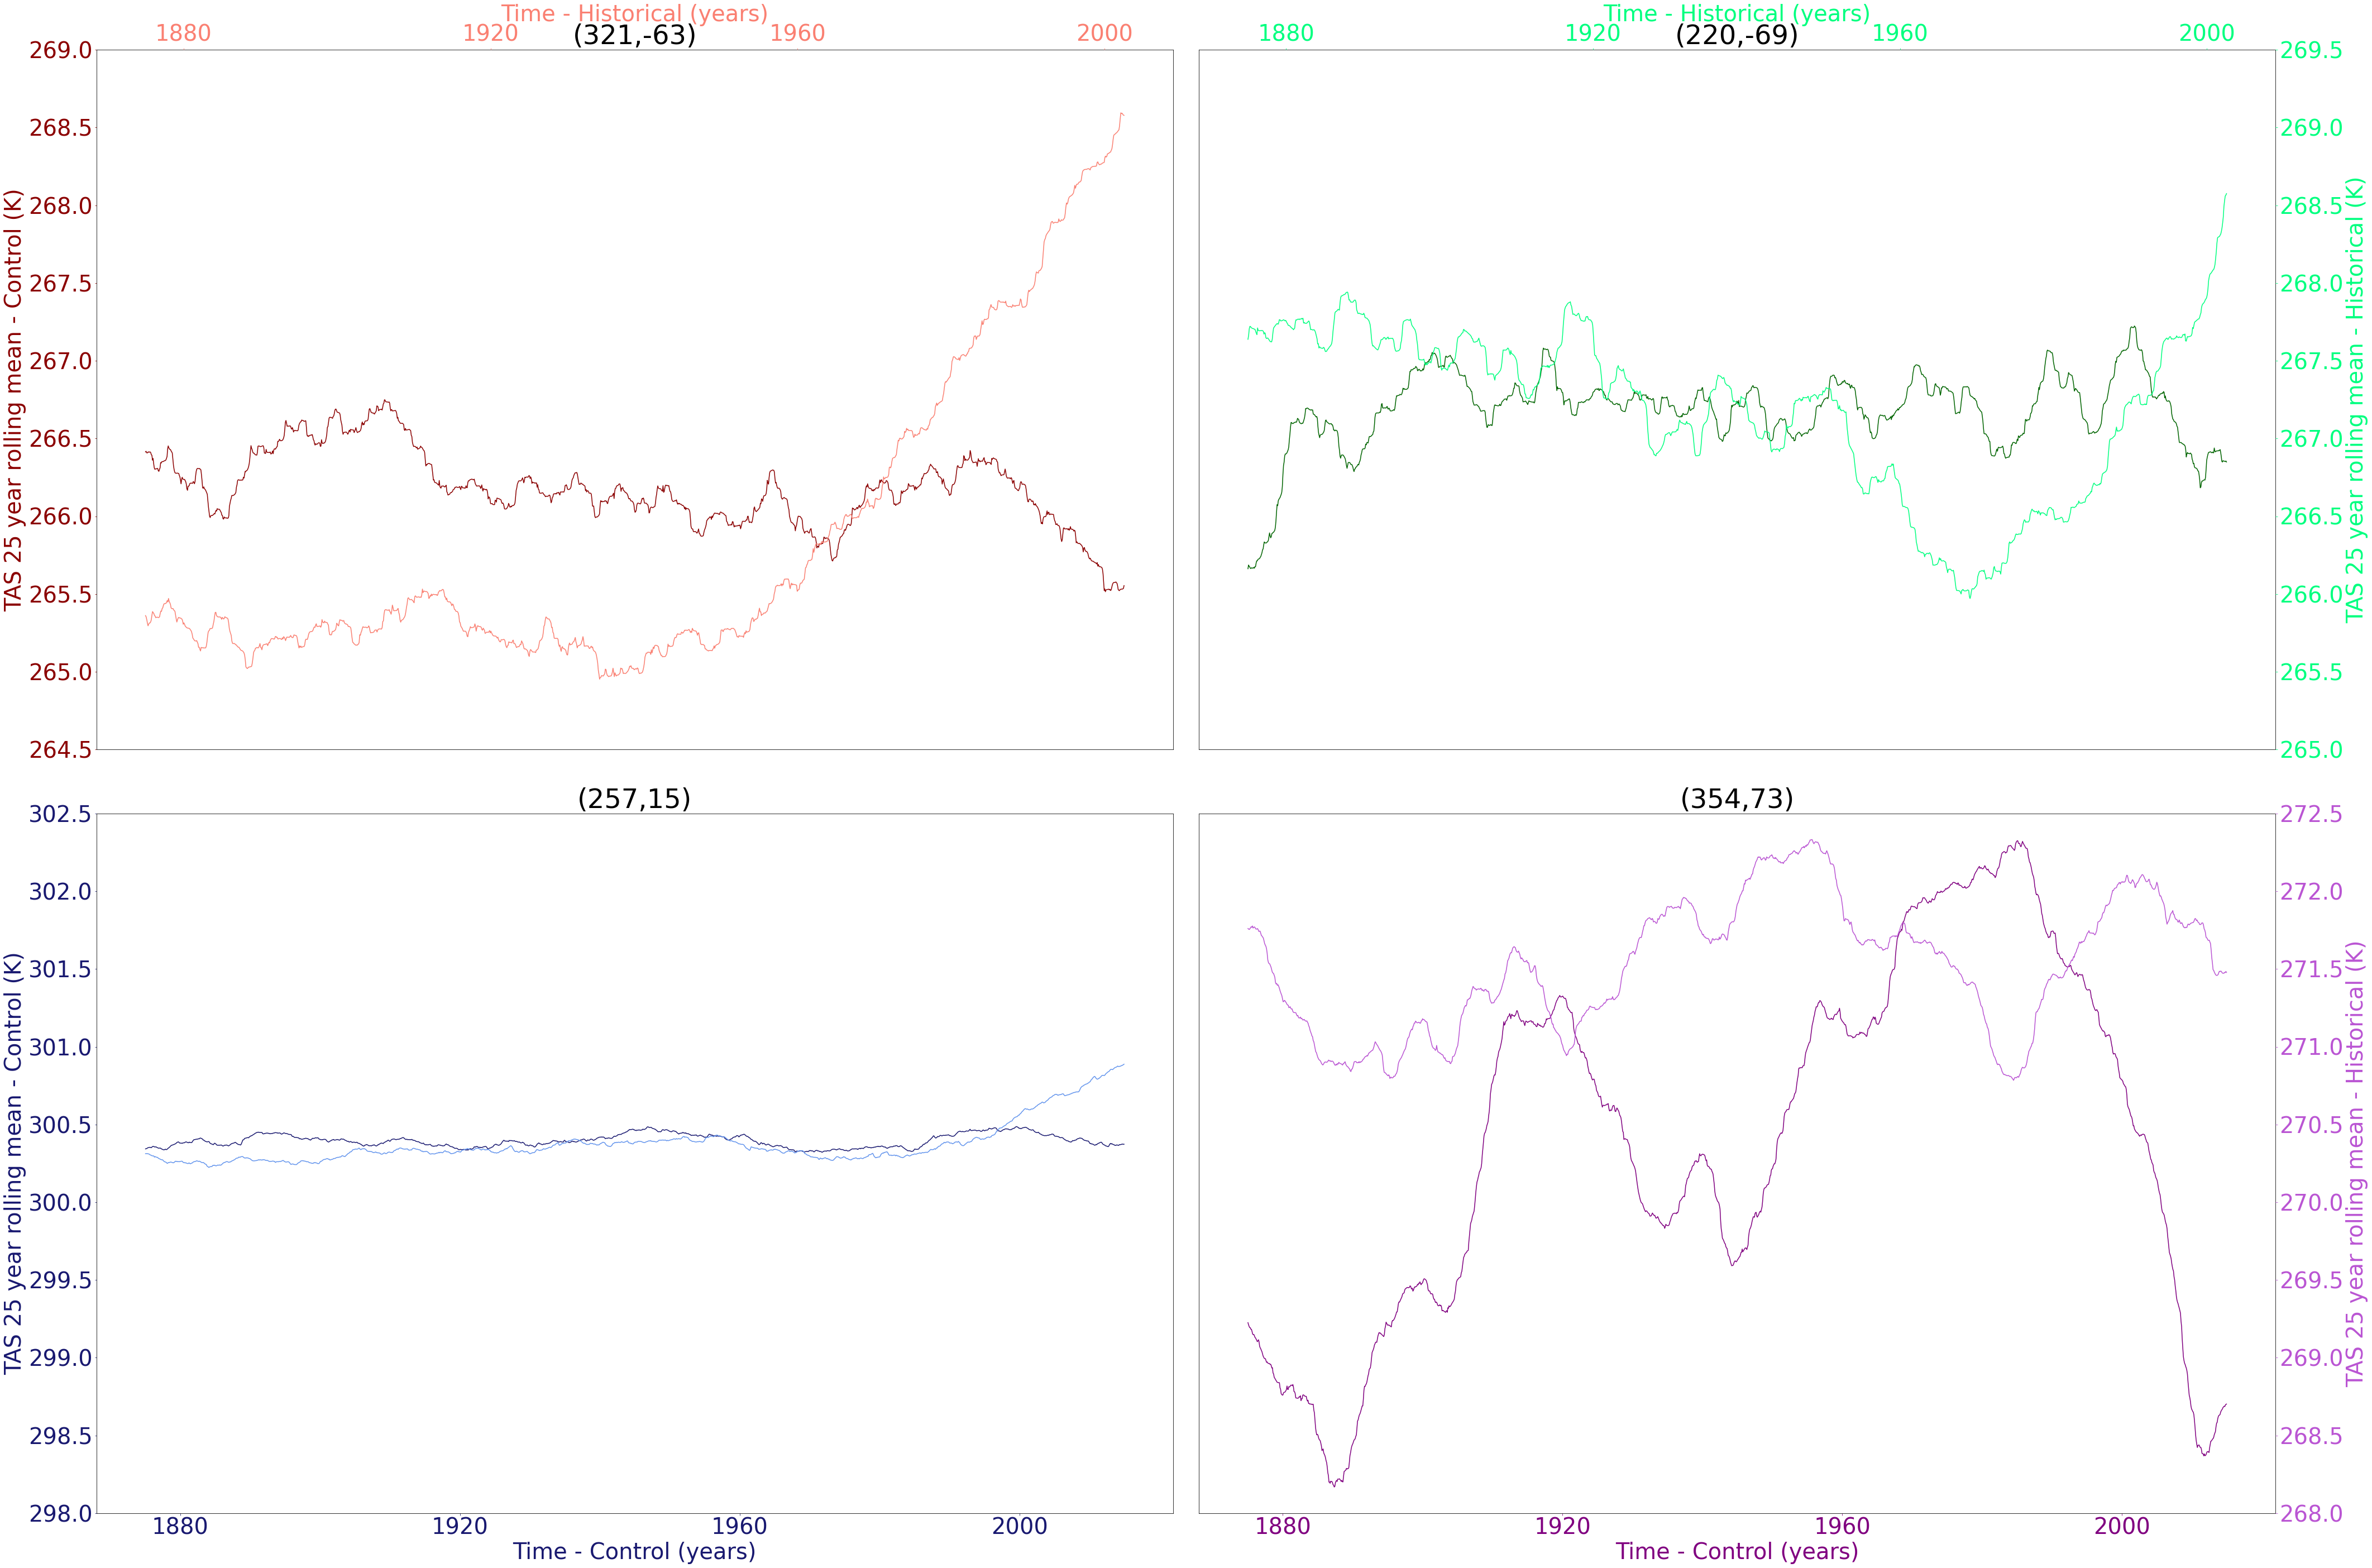

In [79]:
nrow = 1
ncol = 4
fig = plt.figure(figsize=(60, 40))
#grid = ImageGrid(fig, 
#                 111, # as in plt.subplot(111)
#                 nrows_ncols=(nrow,ncol),
#                 axes_pad=0,
#                 share_all=True,)

#for i in range(1):
#    for j in range(2):
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.1)
top=300
bottom=270
font = {'size'   : 40,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

#plt.subplot(gs[0,0])
ax = fig.add_subplot(221, label="Control")
ax2 = fig.add_subplot(221, label="Historical", frame_on=False)
ax.set_title('(321,-63)')
ax.xaxis.set_visible(False)
ax.plot(time_series_cont_hadgem1['time'].values,time_series_cont_hadgem1, color="darkred")
ax.set_xlabel('Time - Control (years)', color="darkred")
ax.set_ylabel('TAS 25 year rolling mean - Control (K)', color="darkred")
ax.set_ylim(bottom=264.5,top=269)
ax.tick_params(axis='x', colors="darkred")
ax.tick_params(axis='y', colors="darkred")

ax2.plot(time_series_hist_hadgem1['time'].values,time_series_hist_hadgem1, color="salmon")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Time - Historical (years)', color="salmon") 
ax2.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="salmon")  
ax2.set_ylim(bottom=264.5,top=269)
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_visible(False)
ax2.tick_params(axis='x', colors="salmon")
ax2.tick_params(axis='y', colors="salmon")

#plt.subplot(gs[0,1])
ax3 = fig.add_subplot(222, label="Control")
ax4 = fig.add_subplot(222, label="Historical", frame_on=False)
ax3.set_title('(220,-69)')
ax3.yaxis.set_visible(False)
ax3.xaxis.set_visible(False)
ax3.plot(time_series_cont_hadgem2['time'].values,time_series_cont_hadgem2, color="darkgreen")
ax3.set_xlabel('Time - Control (years)', color="darkgreen")
ax3.set_ylabel('TAS 25 year rolling mean - Control (K)', color="darkgreen")
ax3.set_ylim(bottom=265,top=269.5)
ax3.tick_params(axis='x', colors="darkgreen")
ax3.tick_params(axis='y', colors="darkgreen")

ax4.plot(time_series_hist_hadgem2['time'].values,time_series_hist_hadgem2, color="springgreen")
ax4.xaxis.tick_top()
ax4.yaxis.tick_right()
#ax4.yaxis.set_visible(False)
ax4.set_xlabel('Time - Historical (years)', color="springgreen") 
ax4.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="springgreen")  
ax4.set_ylim(bottom=265,top=269.5)
ax4.xaxis.set_label_position('top') 
ax4.yaxis.set_label_position('right') 
ax4.tick_params(axis='x', colors="springgreen")
ax4.tick_params(axis='y', colors="springgreen")

ax5 = fig.add_subplot(223, label="Control")
ax6 = fig.add_subplot(223, label="Historical", frame_on=False)
#ax5.yaxis.set_visible(False)
ax5.set_title('(257,15)')
ax5.plot(time_series_cont_hadgem3['time'].values,time_series_cont_hadgem3, color="midnightblue")
ax5.set_xlabel('Time - Control (years)', color="midnightblue")
ax5.set_ylabel('TAS 25 year rolling mean - Control (K)', color="midnightblue")
ax5.set_ylim(bottom=298,top=302.5)
ax5.tick_params(axis='x', colors="midnightblue")
ax5.tick_params(axis='y', colors="midnightblue")

ax6.plot(time_series_hist_hadgem3['time'].values,time_series_hist_hadgem3, color="cornflowerblue")
ax6.xaxis.tick_top()
ax6.yaxis.tick_right()
ax6.xaxis.set_visible(False)
ax6.yaxis.set_visible(False)
ax6.set_xlabel('Time - Historical (years)', color="cornflowerblue") 
ax6.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="cornflowerblue")  
ax6.set_ylim(bottom=298,top=302.5)
ax6.xaxis.set_label_position('top') 
ax6.yaxis.set_label_position('right') 
ax6.tick_params(axis='x', colors="cornflowerblue")
ax6.tick_params(axis='y', colors="cornflowerblue")

ax7 = fig.add_subplot(224, label="Control")
ax8 = fig.add_subplot(224, label="Historical", frame_on=False)
ax7.yaxis.set_visible(False)
ax7.set_title('(354,73)')
ax7.plot(time_series_cont_hadgem4['time'].values,time_series_cont_hadgem4, color="purple")
ax7.set_xlabel('Time - Control (years)', color="purple")
ax7.set_ylabel('TAS 25 year rolling mean - Control (K)', color="purple")
ax7.set_ylim(bottom=268,top=272.5)
ax7.tick_params(axis='x', colors="purple")
ax7.tick_params(axis='y', colors="purple")

ax8.plot(time_series_hist_hadgem4['time'].values,time_series_hist_hadgem4, color="mediumorchid")
ax8.xaxis.tick_top()
ax8.yaxis.tick_right()
ax8.xaxis.set_visible(False)
#ax8.yaxis.set_visible(False)
ax8.set_xlabel('Time - Historical (years)', color="mediumorchid") 
ax8.set_ylabel('TAS 25 year rolling mean - Historical (K)', color="mediumorchid")  
ax8.set_ylim(bottom=268,top=272.5)
ax8.xaxis.set_label_position('top') 
ax8.yaxis.set_label_position('right') 
ax8.tick_params(axis='x', colors="mediumorchid")
ax8.tick_params(axis='y', colors="mediumorchid")

# Get the current axis
ax = pylab.gca()

plt.tight_layout() # do not use this!!
plt.show()

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - HadGEM3')

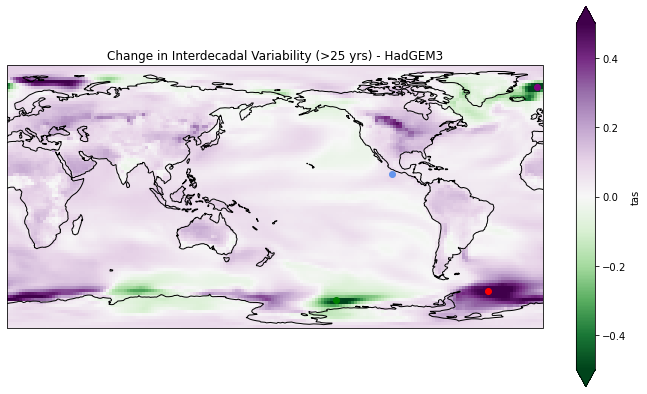

In [81]:
plt.rcParams['figure.figsize'] = [12, 7]
font = {'size'   : 10}
matplotlib.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
delta_hadgem.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.plot(321,-63, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(220,-69, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(257,15, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(354,73, marker='o', color='purple', transform=ccrs.PlateCarree())
plt.title('Change in Interdecadal Variability (>25 yrs) - HadGEM3')

Text(0.5, 1.0, 'Percent Change in Interdecadal Variability (>25 yrs) - HadGEM3')

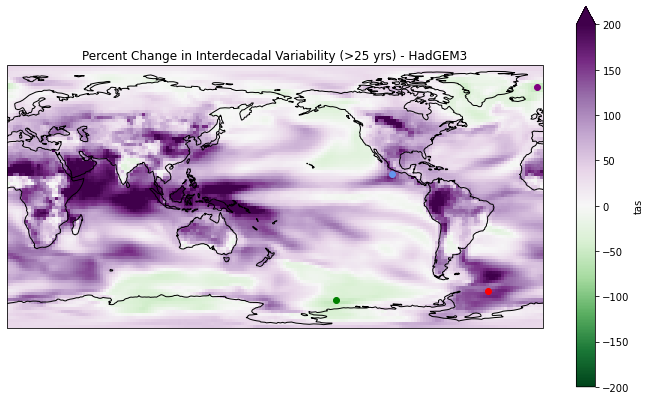

In [83]:
plt.rcParams['figure.figsize'] = [12, 7]
font = {'size'   : 10}
matplotlib.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_hadgem.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.plot(321,-63, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(220,-69, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(257,15, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(354,73, marker='o', color='purple', transform=ccrs.PlateCarree())
plt.title('Percent Change in Interdecadal Variability (>25 yrs) - HadGEM3')

Text(0.5, 1.0, 'Control Interdecadal Variability (>25 yrs) - HadGEM3')

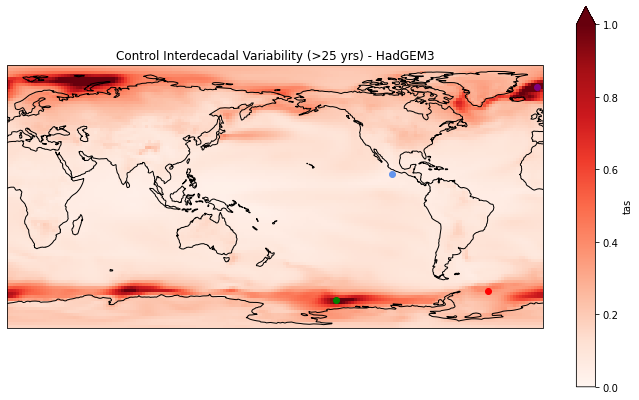

In [87]:
plt.rcParams['figure.figsize'] = [12, 7]
font = {'size'   : 10}
matplotlib.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
hadgem_cont_summary.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1.0)
ax.coastlines(color='black', linewidth=1)
plt.plot(321,-63, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(220,-69, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(257,15, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(354,73, marker='o', color='purple', transform=ccrs.PlateCarree())
plt.title('Control Interdecadal Variability (>25 yrs) - HadGEM3')

Text(0.5, 1.0, 'Control Interdecadal Variability (>25 yrs) - HadGEM3')

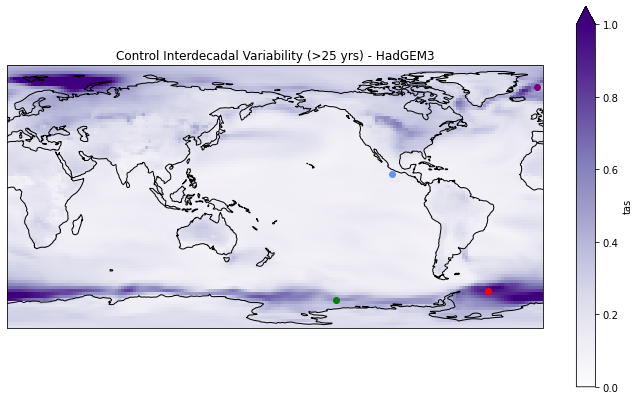

In [88]:
plt.rcParams['figure.figsize'] = [12, 7]
font = {'size'   : 10}
matplotlib.rc('font', **font)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
hadgem_hist_summary.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Purples', vmin=0, vmax=1.0)
ax.coastlines(color='black', linewidth=1)
plt.plot(321,-63, marker='o', color='red', transform=ccrs.PlateCarree())
plt.plot(220,-69, marker='o', color='green', transform=ccrs.PlateCarree())
plt.plot(257,15, marker='o', color='cornflowerblue', transform=ccrs.PlateCarree())
plt.plot(354,73, marker='o', color='purple', transform=ccrs.PlateCarree())
plt.title('Control Interdecadal Variability (>25 yrs) - HadGEM3')